# Data Loading & Path Validation

In [ ]:
# ============================================================
# STAGE 1 — Data Loading & Path Validation (ONE CELL, Kaggle-ready) — REVISI FULL
# Dataset root (fixed): /kaggle/input/physionet-ecg-image-digitization
#
# Sesuai struktur dataset:
# - train.csv, test.csv, sample_submission.parquet
# - train/<id>/<id>.csv + train/<id>/<id>-*.png (multi-variant)
# - test/<base_id>.png (1 image per base_id)
#
# Output globals:
# - ROOT, PATHS
# - df_train_meta, df_test_meta
# - SAMPLE_SUB_PATH (path template submission)
# - helper path functions
# - helper untuk baca sample_submission (head / full) secara memory-safe
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------
# 1) Fixed dataset root
# ----------------------------
ROOT = Path("/kaggle/input/physionet-ecg-image-digitization")
if not ROOT.exists():
    raise FileNotFoundError(f"ROOT not found: {ROOT}")

PATHS = {
    "ROOT": ROOT,
    "TRAIN_CSV": ROOT / "train.csv",
    "TEST_CSV": ROOT / "test.csv",
    "SAMPLE_SUB_PARQUET": ROOT / "sample_submission.parquet",
    "SAMPLE_SUB_CSV": ROOT / "sample_submission.csv",  # fallback jika ada
    "TRAIN_DIR": ROOT / "train",
    "TEST_DIR": ROOT / "test",
}

# ----------------------------
# 2) Validate critical files/folders
# ----------------------------
must_exist = [PATHS["TRAIN_CSV"], PATHS["TEST_CSV"], PATHS["TRAIN_DIR"], PATHS["TEST_DIR"]]
missing = [p for p in must_exist if not p.exists()]
if missing:
    raise FileNotFoundError("Missing required paths:\n" + "\n".join([str(p) for p in missing]))

if PATHS["SAMPLE_SUB_PARQUET"].exists():
    SAMPLE_SUB_PATH = PATHS["SAMPLE_SUB_PARQUET"]
elif PATHS["SAMPLE_SUB_CSV"].exists():
    SAMPLE_SUB_PATH = PATHS["SAMPLE_SUB_CSV"]
else:
    raise FileNotFoundError("Missing sample submission (parquet/csv) in dataset root.")

# ----------------------------
# 3) Load metadata (small, safe)
# ----------------------------
df_train_meta = pd.read_csv(PATHS["TRAIN_CSV"])
df_test_meta  = pd.read_csv(PATHS["TEST_CSV"])

# ----------------------------
# 4) Schema checks
# ----------------------------
need_train_cols = {"id", "fs", "sig_len"}
need_test_cols  = {"id", "lead", "fs", "number_of_rows"}

if not need_train_cols.issubset(df_train_meta.columns):
    raise ValueError(f"train.csv missing columns {sorted(need_train_cols - set(df_train_meta.columns))}. Found: {list(df_train_meta.columns)}")
if not need_test_cols.issubset(df_test_meta.columns):
    raise ValueError(f"test.csv missing columns {sorted(need_test_cols - set(df_test_meta.columns))}. Found: {list(df_test_meta.columns)}")

# Cast basic dtypes safely
df_train_meta["id"] = df_train_meta["id"].astype(str)
df_test_meta["id"]  = df_test_meta["id"].astype(str)
df_test_meta["lead"] = df_test_meta["lead"].astype(str)

# ----------------------------
# 5) Helper path functions (sesuai struktur dataset)
# ----------------------------
def train_record_dir(base_id: str) -> Path:
    return PATHS["TRAIN_DIR"] / str(base_id)

def train_signal_csv(base_id: str) -> Path:
    return train_record_dir(base_id) / f"{base_id}.csv"

def train_image_paths(base_id: str):
    # multi-variant images: <id>-*.png
    d = train_record_dir(base_id)
    if not d.exists():
        return []
    return sorted(d.glob(f"{base_id}-*.png"))

def test_image_path(base_id: str) -> Path:
    # test images: test/<id>.png
    return PATHS["TEST_DIR"] / f"{base_id}.png"

# ----------------------------
# 6) Quick stats & sanity summaries
# ----------------------------
print("=== ROOT ===")
print(str(ROOT))

print("\n=== TRAIN META ===")
print("rows:", len(df_train_meta), "| cols:", list(df_train_meta.columns))
print("fs distribution:\n", df_train_meta["fs"].value_counts(dropna=False).sort_index())
sig_len_expected = (df_train_meta["fs"].astype(float) * 10.0).round().astype("Int64")
sig_len_ok = (df_train_meta["sig_len"].astype("Int64") == sig_len_expected)
print("sig_len matches 10s*fs:", f"{sig_len_ok.mean()*100:.2f}%")

print("\n=== TEST META ===")
print("rows:", len(df_test_meta), "| cols:", list(df_test_meta.columns))
print("unique base_id:", df_test_meta["id"].nunique())
print("unique leads:", sorted(df_test_meta["lead"].unique().tolist()))
print("fs distribution:\n", df_test_meta["fs"].value_counts(dropna=False).sort_index())
print("number_of_rows summary:\n", df_test_meta["number_of_rows"].describe())

# ----------------------------
# 7) Path validation (sesuai struktur)
# ----------------------------
# 7A) Train folder check
train_dirs_on_disk = set(os.listdir(PATHS["TRAIN_DIR"]))
train_ids = df_train_meta["id"].unique().tolist()
train_ids_set = set(train_ids)

missing_train_dirs = sorted(list(train_ids_set - train_dirs_on_disk))
extra_train_dirs = sorted(list(train_dirs_on_disk - train_ids_set))

print("\n=== TRAIN PATH VALIDATION ===")
print("train/ dirs on disk:", len(train_dirs_on_disk))
print("train ids in train.csv:", len(train_ids_set))
print("missing train/<id>/ dirs:", len(missing_train_dirs))
if missing_train_dirs[:10]:
    print("  examples:", missing_train_dirs[:10])
print("extra train/<id>/ dirs not in train.csv:", len(extra_train_dirs))
if extra_train_dirs[:10]:
    print("  examples:", extra_train_dirs[:10])

# 7B) Train GT CSV existence (sampled for speed)
n_train = len(train_ids)
rng = np.random.RandomState(2026)
check_ids = train_ids if n_train <= 3000 else rng.choice(train_ids, size=1000, replace=False).tolist()

missing_gt = []
for tid in check_ids:
    if not train_signal_csv(tid).exists():
        missing_gt.append(tid)

mode = "FULL" if n_train <= 3000 else "SAMPLED"
print(f"train/<id>/<id>.csv existence check: {mode} | checked={len(check_ids)}")
print("missing GT csv:", len(missing_gt))
if missing_gt[:10]:
    print("  examples:", missing_gt[:10])

# 7C) Train PNG variants existence (sampled)
img_check_ids = train_ids if n_train <= 300 else rng.choice(train_ids, size=200, replace=False).tolist()
missing_imgs = []
variant_counts = []

for tid in img_check_ids:
    imgs = train_image_paths(tid)
    variant_counts.append(len(imgs))
    if len(imgs) == 0:
        missing_imgs.append(tid)

print(f"train images existence check: {('FULL' if n_train <= 300 else 'SAMPLED')} | checked={len(img_check_ids)}")
print("missing train/<id>/<id>-*.png:", len(missing_imgs))
if missing_imgs[:10]:
    print("  examples:", missing_imgs[:10])
if variant_counts:
    vc = np.array(variant_counts, dtype=np.int32)
    print("variant count (sample) min/median/max:", int(vc.min()), float(np.median(vc)), int(vc.max()))

# 7D) Test PNG existence (full, usually ~1000 images)
test_base_ids = df_test_meta["id"].unique().tolist()
missing_test_imgs = []
for bid in test_base_ids:
    if not test_image_path(bid).exists():
        missing_test_imgs.append(bid)

print("\n=== TEST PATH VALIDATION ===")
print("unique test base_id:", len(test_base_ids))
print("missing test/<id>.png:", len(missing_test_imgs))
if missing_test_imgs[:10]:
    print("  examples:", missing_test_imgs[:10])

# ----------------------------
# 8) Sample submission: memory-safe inspection (JANGAN load full DF besar di Stage 1)
# ----------------------------
print("\n=== SAMPLE SUBMISSION (MEMORY-SAFE INSPECTION) ===")
print("template path:", str(SAMPLE_SUB_PATH))

def read_sample_submission_head(n=5):
    """Baca beberapa baris template submission untuk cek format tanpa boros RAM."""
    p = SAMPLE_SUB_PATH
    if p.suffix.lower() == ".parquet":
        try:
            import pyarrow.parquet as pq
            pf = pq.ParquetFile(p)
            # Ambil sebagian kecil dari row group pertama
            tbl = pf.read_row_group(0, columns=["id", "value"])
            df = tbl.to_pandas()
            return df.head(n), pf.metadata.num_rows
        except Exception as e:
            raise RuntimeError(f"Failed to read parquet head via pyarrow: {e}")
    else:
        # CSV fallback: ambil head saja
        df = pd.read_csv(p, nrows=n)
        # row count CSV full tidak dihitung di sini (mahal), return None
        return df, None

df_sub_head, template_rows = read_sample_submission_head(n=5)
print("head:\n", df_sub_head)

# Expected template row count = sum(number_of_rows) across all (base_id, lead) in test.csv
expected_rows = int(df_test_meta["number_of_rows"].astype(np.int64).sum())
print("expected rows from test.csv sum(number_of_rows):", expected_rows)
if template_rows is not None:
    print("template total rows (parquet metadata):", int(template_rows))
    if int(template_rows) != expected_rows:
        print("[WARN] template rowcount != expected_rows. Check test.csv vs template.")
else:
    print("template total rows: (CSV) not checked here")

# Quick id-format check on head
id_parts = df_sub_head["id"].astype(str).str.rsplit("_", n=2, expand=True)
if id_parts.shape[1] != 3:
    raise ValueError("Unexpected id format in sample submission head (cannot split into 3 parts).")
tmp_base_id = id_parts[0]
tmp_row_id  = pd.to_numeric(id_parts[1], errors="coerce")
tmp_lead    = id_parts[2]
if tmp_row_id.isna().any():
    raise ValueError("row_id parse failed on sample submission head (NaN found).")
print("parsed head example -> base_id/row_id/lead:")
print(pd.DataFrame({"base_id": tmp_base_id, "row_id": tmp_row_id.astype(int), "lead": tmp_lead}).head())

# ----------------------------
# 9) Optional: actually open a few PNGs (sanity that PIL can read)
# ----------------------------
print("\n=== OPTIONAL: OPEN FEW PNG (SANITY) ===")
try:
    from PIL import Image, ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    # train: open first variant for 2 random ids
    s_train = rng.choice(train_ids, size=min(2, len(train_ids)), replace=False).tolist() if len(train_ids) else []
    for tid in s_train:
        imgs = train_image_paths(tid)
        if not imgs:
            print(f"[WARN] no train png for id={tid}")
            continue
        p = imgs[0]
        with Image.open(p) as im:
            print(f"train id={tid} | file={p.name} | size={im.size} | mode={im.mode}")

    # test: open 2 random base_ids
    s_test = rng.choice(test_base_ids, size=min(2, len(test_base_ids)), replace=False).tolist() if len(test_base_ids) else []
    for bid in s_test:
        p = test_image_path(bid)
        with Image.open(p) as im:
            print(f"test base_id={bid} | file={p.name} | size={im.size} | mode={im.mode}")

except Exception as e:
    print("[WARN] PIL open check skipped (PIL not available or error):", str(e))

print("\n[OK] STAGE 1 completed. Globals ready: ROOT, PATHS, df_train_meta, df_test_meta, SAMPLE_SUB_PATH")


# Lead Duration Rules & Target Length Mapping

In [ ]:
# ============================================================
# STAGE 2 — Lead Duration Rules & Target Length Mapping (ONE CELL, Kaggle-ready)
#
# Prasyarat: STAGE 1 sudah dijalankan dan menghasilkan:
# - df_test_meta (cols: id, lead, fs, number_of_rows)
#
# Output globals:
# - LEADS_12 (list urutan lead standar)
# - TEST_BASE_IDS (list base_id unik)
# - TARGET_LEN_MAP  : dict (base_id, lead) -> int target_len  (pakai number_of_rows)
# - FS_MAP          : dict base_id -> int fs
# - TEST_REQ_TABLE  : DataFrame ringkas (base_id, lead, fs, target_len, expected_len_rule, rule_match)
#
# Catatan:
# - Kita patuhi number_of_rows dari test.csv (paling aman).
# - Kita juga cek konsistensi dengan aturan kompetisi:
#     Lead II ~ fs*10, lead lain ~ fs*2.5 (floor)
# ============================================================

import numpy as np
import pandas as pd

# ----------------------------
# 0) Require STAGE 1 globals
# ----------------------------
for need in ["df_test_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")

df = df_test_meta.copy()

# ----------------------------
# 1) Normalize / basic checks
# ----------------------------
# Ensure types
df["id"] = df["id"].astype(str)
df["lead"] = df["lead"].astype(str)
df["fs"] = pd.to_numeric(df["fs"], errors="raise").astype(int)
df["number_of_rows"] = pd.to_numeric(df["number_of_rows"], errors="raise").astype(int)

need_cols = {"id", "lead", "fs", "number_of_rows"}
if not need_cols.issubset(df.columns):
    raise ValueError(f"test.csv must include columns {sorted(need_cols)}. Found: {list(df.columns)}")

# Standard 12 leads (canonical order)
LEADS_12 = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

# Validate lead set
lead_set = set(df["lead"].unique().tolist())
missing_leads = [x for x in LEADS_12 if x not in lead_set]
extra_leads = sorted(list(lead_set - set(LEADS_12)))
if missing_leads:
    raise ValueError(f"test.csv missing leads: {missing_leads}")
if extra_leads:
    print("[WARN] Extra/unexpected leads in test.csv:", extra_leads)

# ----------------------------
# 2) Build base_id list and fs map (ensure consistent fs per base_id)
# ----------------------------
TEST_BASE_IDS = sorted(df["id"].unique().tolist())

# fs consistency check per base_id
fs_per_id = df.groupby("id")["fs"].nunique()
bad_fs = fs_per_id[fs_per_id != 1]
if len(bad_fs) > 0:
    # still build but warn loudly; this should not happen in this comp
    print("[WARN] Some base_id have multiple fs values. Examples:\n", bad_fs.head(10))

FS_MAP = df.groupby("id")["fs"].first().to_dict()

# ----------------------------
# 3) Target length mapping (authoritative: number_of_rows)
# ----------------------------
# (base_id, lead) -> target_len
TARGET_LEN_MAP = {}
dup_rows = df.duplicated(subset=["id","lead"]).sum()
if dup_rows:
    # duplicates would cause ambiguity
    raise ValueError(f"test.csv has duplicate (id, lead) rows: {int(dup_rows)}")

for r in df.itertuples(index=False):
    TARGET_LEN_MAP[(r.id, r.lead)] = int(r.number_of_rows)

# ----------------------------
# 4) Rule-based expected length (for diagnostics only)
# ----------------------------
# Competition rule (as described): II ~ floor(fs*10), others ~ floor(fs*2.5)
def expected_len_from_rule(fs: int, lead: str) -> int:
    if lead == "II":
        return int(np.floor(fs * 10.0))
    else:
        return int(np.floor(fs * 2.5))

df["expected_len_rule"] = [
    expected_len_from_rule(int(fs), str(lead)) for fs, lead in zip(df["fs"].values, df["lead"].values)
]
df["rule_match"] = (df["number_of_rows"].astype(int) == df["expected_len_rule"].astype(int))

# Create a clean requirement table
TEST_REQ_TABLE = df.rename(columns={"id":"base_id", "number_of_rows":"target_len"})[
    ["base_id", "lead", "fs", "target_len", "expected_len_rule", "rule_match"]
].sort_values(["base_id", "lead"]).reset_index(drop=True)

# ----------------------------
# 5) Summary prints
# ----------------------------
print("=== STAGE 2 SUMMARY ===")
print("base_id count:", len(TEST_BASE_IDS))
print("lead count per base_id (should be 12):")
print(df.groupby("id")["lead"].nunique())

# show mismatches if any
mismatch = TEST_REQ_TABLE[~TEST_REQ_TABLE["rule_match"]]
if len(mismatch) > 0:
    print("\n[WARN] number_of_rows != rule expected for some rows (we will still trust number_of_rows):")
    display(mismatch.head(20))
else:
    print("\nrule_match: 100% (number_of_rows consistent with II=10s, others=2.5s)")

print("\nTarget length distribution:")
print(TEST_REQ_TABLE["target_len"].describe())

print("\nExample rows:")
print(TEST_REQ_TABLE.head(12))

print("\n[OK] STAGE 2 completed. Globals ready: LEADS_12, TEST_BASE_IDS, TARGET_LEN_MAP, FS_MAP, TEST_REQ_TABLE")


# Image Preprocessing (Global Rectification)

In [ ]:
# ============================================================
# STAGE 3 — Image Preprocessing (Global Rectification) (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Baca PNG (RGBA) -> RGB (alpha diblend ke putih)
# - (Opsional) Deskew rotasi kecil berbasis deteksi garis (Hough) -> lebih stabil untuk crop & segmentasi
# - (Opsional) Contrast normalization ringan (CLAHE) untuk memperjelas ink waveform
# - Cache hasil ke /kaggle/working agar stage berikutnya bisa load cepat (tanpa preprocess ulang)
#
# Prasyarat:
# - PATHS, df_test_meta sudah ada (STAGE 1)
# - TEST_BASE_IDS sudah ada (STAGE 2)  [kalau belum, akan dihitung dari df_test_meta]
#
# Output globals:
# - PREPROC_CFG, PREPROC_ID, PREPROC_DIR
# - get_preproc_test_path(base_id)
# - load_preproc_rgb(path_or_base_id, split="test")
# - PREPROC_DONE_TEST (list base_id yang berhasil diproses)
# ============================================================

import os, json, hashlib
from pathlib import Path
import numpy as np

# PIL for robust PNG reading (RGBA)
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Optional OpenCV for deskew/clahe (fallback jika tidak ada)
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False

# ----------------------------
# 0) Require basics
# ----------------------------
for need in ["PATHS", "df_test_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")

if "TEST_BASE_IDS" not in globals():
    TEST_BASE_IDS = sorted(df_test_meta["id"].astype(str).unique().tolist())

# ----------------------------
# 1) Preprocess config (ubah di sini kalau mau tuning)
# ----------------------------
PREPROC_CFG = {
    "version": 1,
    "apply_deskew": True,        # deskew rotasi kecil
    "max_abs_deg": 5.0,          # clamp rotasi maksimum (derajat)
    "deskew_downscale_max": 900, # downscale untuk estimasi angle (biar cepat)
    "apply_clahe": False,        # default OFF (aman). Nyalakan jika perlu
    "clahe_clip_limit": 2.0,
    "clahe_grid": (8, 8),
    "save_format": "png",        # simpan cache sebagai png RGB
    "jpeg_quality": 95,          # jika ganti ke jpg di masa depan
}

# build cfg hash id for versioned caching
_cfg_bytes = json.dumps(PREPROC_CFG, sort_keys=True).encode("utf-8")
PREPROC_ID = hashlib.md5(_cfg_bytes).hexdigest()[:12]

PREPROC_DIR = Path("/kaggle/working/physionet_ecg_cache/preproc") / f"cfg_{PREPROC_ID}"
PREPROC_DIR_TEST = PREPROC_DIR / "test"
PREPROC_DIR_TRAIN = PREPROC_DIR / "train"  # disiapkan, tapi cell ini fokus test
PREPROC_DIR_TEST.mkdir(parents=True, exist_ok=True)
PREPROC_DIR_TRAIN.mkdir(parents=True, exist_ok=True)

# save cfg once
cfg_path = PREPROC_DIR / "preproc_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(PREPROC_CFG, indent=2, sort_keys=True))

print("=== STAGE 3 CONFIG ===")
print("HAS_CV2:", _HAS_CV2)
print("PREPROC_ID:", PREPROC_ID)
print("PREPROC_DIR:", str(PREPROC_DIR))

# ----------------------------
# 2) Utilities
# ----------------------------
def _rgba_to_rgb_white(rgba: np.ndarray) -> np.ndarray:
    """RGBA uint8 -> RGB uint8 with alpha blended over white background."""
    if rgba.ndim != 3 or rgba.shape[2] not in (3, 4):
        raise ValueError(f"Expected HxWx3/4 array, got shape={rgba.shape}")
    if rgba.shape[2] == 3:
        return rgba.astype(np.uint8)

    rgb = rgba[:, :, :3].astype(np.float32)
    a = rgba[:, :, 3:4].astype(np.float32) / 255.0
    out = rgb * a + 255.0 * (1.0 - a)
    return np.clip(out, 0, 255).astype(np.uint8)

def _resize_for_angle(gray_u8: np.ndarray, max_side: int) -> np.ndarray:
    h, w = gray_u8.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return gray_u8
    scale = max_side / float(m)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    if _HAS_CV2:
        return cv2.resize(gray_u8, (nw, nh), interpolation=cv2.INTER_AREA)
    # PIL fallback
    im = Image.fromarray(gray_u8)
    im = im.resize((nw, nh), resample=Image.BILINEAR)
    return np.array(im)

def _estimate_skew_deg(gray_u8: np.ndarray, cfg: dict) -> float:
    """Estimate small skew angle in degrees using line segments (requires cv2). Fallback -> 0."""
    if not _HAS_CV2 or not cfg.get("apply_deskew", True):
        return 0.0

    g = _resize_for_angle(gray_u8, cfg.get("deskew_downscale_max", 900))
    # blur + edge
    g_blur = cv2.GaussianBlur(g, (5, 5), 0)
    edges = cv2.Canny(g_blur, 50, 150, apertureSize=3)

    # Probabilistic Hough lines
    h, w = edges.shape[:2]
    min_len = max(60, int(0.15 * min(h, w)))
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180.0,
        threshold=120,
        minLineLength=min_len,
        maxLineGap=15
    )

    if lines is None or len(lines) < 10:
        return 0.0

    angles = []
    for x1, y1, x2, y2 in lines[:, 0]:
        dx = (x2 - x1)
        dy = (y2 - y1)
        if dx == 0:
            continue
        ang = np.degrees(np.arctan2(dy, dx))
        # normalize to [-90, 90)
        while ang < -90:
            ang += 180
        while ang >= 90:
            ang -= 180
        # focus near horizontal lines (grid/waveform baseline)
        if abs(ang) <= 30:
            angles.append(ang)

    if len(angles) < 10:
        return 0.0

    med = float(np.median(angles))
    max_abs = float(cfg.get("max_abs_deg", 5.0))
    med = float(np.clip(med, -max_abs, max_abs))
    return med

def _rotate_rgb(rgb_u8: np.ndarray, deg: float) -> np.ndarray:
    """Rotate image by deg (positive = CCW). Uses cv2 if available, else PIL."""
    if abs(deg) < 1e-6:
        return rgb_u8

    h, w = rgb_u8.shape[:2]
    if _HAS_CV2:
        # rotate around center, keep same canvas size
        M = cv2.getRotationMatrix2D((w / 2.0, h / 2.0), deg, 1.0)
        out = cv2.warpAffine(
            rgb_u8, M, (w, h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(255, 255, 255)
        )
        return out

    im = Image.fromarray(rgb_u8)
    im = im.rotate(deg, resample=Image.BILINEAR, expand=False, fillcolor=(255, 255, 255))
    return np.array(im)

def _apply_clahe_rgb(rgb_u8: np.ndarray, cfg: dict) -> np.ndarray:
    """Apply CLAHE on L channel in LAB space (requires cv2). Fallback -> no-op."""
    if not cfg.get("apply_clahe", False):
        return rgb_u8
    if not _HAS_CV2:
        return rgb_u8

    clip = float(cfg.get("clahe_clip_limit", 2.0))
    grid = tuple(cfg.get("clahe_grid", (8, 8)))
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)

    lab = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2, A, B])
    out = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    return out

def get_preproc_test_path(base_id: str) -> Path:
    return PREPROC_DIR_TEST / f"{base_id}.{PREPROC_CFG['save_format']}"

def preprocess_one_image_to_cache(in_path: Path, out_path: Path, cfg: dict) -> dict:
    """Preprocess single image file, save to out_path (RGB). Return meta dict."""
    with Image.open(in_path) as im:
        im = im.convert("RGBA")
        rgba = np.array(im)

    rgb = _rgba_to_rgb_white(rgba)
    gray = np.array(Image.fromarray(rgb).convert("L"))

    deg = _estimate_skew_deg(gray, cfg) if cfg.get("apply_deskew", True) else 0.0
    if cfg.get("apply_deskew", True) and abs(deg) > 1e-6:
        # rotate opposite to correct skew (if estimated angle is line tilt)
        rgb = _rotate_rgb(rgb, -deg)

    rgb = _apply_clahe_rgb(rgb, cfg)

    # save
    out_path.parent.mkdir(parents=True, exist_ok=True)
    Image.fromarray(rgb).save(out_path)

    meta = {
        "in_path": str(in_path),
        "out_path": str(out_path),
        "deskew_deg_est": float(deg),
        "final_mode": "RGB",
        "shape_hw": [int(rgb.shape[0]), int(rgb.shape[1])],
    }
    return meta

def load_preproc_rgb(path_or_base_id, split="test") -> np.ndarray:
    """Load preprocessed RGB image as uint8 numpy array. Accepts base_id (test) or explicit path."""
    if isinstance(path_or_base_id, (str, int)):
        if split != "test":
            raise ValueError("For base_id input, split must be 'test' in this helper.")
        p = get_preproc_test_path(str(path_or_base_id))
    else:
        p = Path(path_or_base_id)

    if not p.exists():
        raise FileNotFoundError(f"Preprocessed file not found: {p}")
    with Image.open(p) as im:
        im = im.convert("RGB")
        return np.array(im)

# ----------------------------
# 3) Run preprocessing for TEST images (safe for hidden test too)
# ----------------------------
PREPROC_DONE_TEST = []
PREPROC_META_TEST = []

print("\n=== PREPROCESS TEST IMAGES ===")
print("test base_id:", len(TEST_BASE_IDS))

for bid in TEST_BASE_IDS:
    bid = str(bid)
    in_path = PATHS["TEST_DIR"] / f"{bid}.png"
    out_path = get_preproc_test_path(bid)
    meta_path = out_path.with_suffix(".json")

    if out_path.exists() and meta_path.exists():
        # already cached
        PREPROC_DONE_TEST.append(bid)
        continue

    if not in_path.exists():
        raise FileNotFoundError(f"Missing test image: {in_path}")

    meta = preprocess_one_image_to_cache(in_path, out_path, PREPROC_CFG)
    meta_path.write_text(json.dumps(meta, indent=2, sort_keys=True))
    PREPROC_DONE_TEST.append(bid)
    PREPROC_META_TEST.append(meta)

print("cached test images:", len(PREPROC_DONE_TEST))
if PREPROC_META_TEST:
    # print a few meta examples
    print("meta examples (up to 3):")
    for m in PREPROC_META_TEST[:3]:
        print({"id": Path(m["in_path"]).stem, "deskew_deg_est": m["deskew_deg_est"], "shape_hw": m["shape_hw"]})

print("\n[OK] STAGE 3 completed. Use `get_preproc_test_path(base_id)` or `load_preproc_rgb(base_id)` for next stages.")


# Layout Localization & Cropping

In [ ]:
# ============================================================
# STAGE 4 — Layout Localization & Cropping (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Ambil gambar hasil PREPROC (STAGE 3) untuk setiap test base_id
# - Deteksi "content bbox" (area ECG) secara ringan (non-white bbox)
# - Terapkan template layout 12-lead (3x4 panel) + rhythm strip Lead II (10s)
# - Simpan crop ke cache (/kaggle/working) agar stage berikutnya cepat
#
# Prasyarat:
# - PATHS, df_test_meta (STAGE 1)
# - TEST_BASE_IDS, LEADS_12 (STAGE 2)  [kalau belum ada, dibuat otomatis dari df_test_meta]
# - PREPROC_DIR, get_preproc_test_path (STAGE 3)  [kalau belum ada, tetap bisa load dari PATHS["TEST_DIR"]]
#
# Output globals:
# - LAYOUT_CFG, LAYOUT_ID, CROP_DIR
# - LEAD_GRID_ORDER (matrix 3x4 lead)
# - CROPS_META (dict): CROPS_META[base_id] = { "content_bbox":..., "boxes": {lead: [x0,y0,x1,y1], "II_rhythm": ... } }
# - get_crop_path(base_id, key)
# - load_crop_rgb(base_id, key)
#
# Catatan:
# - Ini baseline layout yang biasanya cocok untuk format standar 12-lead:
#   Row1: I, aVR, V1, V4
#   Row2: II, aVL, V2, V5
#   Row3: III, aVF, V3, V6
#   Rhythm strip: II di bawah (full width)
# - Jika nanti ternyata layout berbeda, stage ini yang akan kamu upgrade (tetap modular).
# ============================================================

import os, json, hashlib
from pathlib import Path
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ----------------------------
# 0) Require basics
# ----------------------------
for need in ["PATHS", "df_test_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")

if "TEST_BASE_IDS" not in globals():
    TEST_BASE_IDS = sorted(df_test_meta["id"].astype(str).unique().tolist())

if "LEADS_12" not in globals():
    LEADS_12 = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]

# Preproc availability
_HAS_PREPROC = ("get_preproc_test_path" in globals()) and ("PREPROC_DIR" in globals())

# ----------------------------
# 1) Layout config (tuning knobs)
# ----------------------------
LAYOUT_CFG = {
    "version": 1,
    "use_content_bbox": True,     # detect bbox non-white untuk adapt margin
    "white_thr": 245,             # pixel dianggap "white" jika semua channel >= thr
    "min_content_frac": 0.05,     # kalau content terlalu sedikit -> fallback full image
    # region fractions inside content bbox
    "x_left_frac": 0.03,          # kiri dalam content
    "x_right_frac": 0.97,         # kanan dalam content
    "grid_top_frac": 0.08,        # mulai area panel lead
    "grid_bottom_frac": 0.78,     # akhir area panel lead (sebelum rhythm)
    "rhythm_top_frac": 0.78,      # mulai rhythm strip
    "rhythm_bottom_frac": 0.97,   # akhir rhythm strip
    # padding inside each crop box (relative to cell size)
    "cell_pad_x_frac": 0.015,
    "cell_pad_y_frac": 0.06,
    "rhythm_pad_x_frac": 0.01,
    "rhythm_pad_y_frac": 0.08,
    # save format
    "save_format": "png",
}

_cfg_bytes = json.dumps(LAYOUT_CFG, sort_keys=True).encode("utf-8")
LAYOUT_ID = hashlib.md5(_cfg_bytes).hexdigest()[:12]

CROP_DIR = Path("/kaggle/working/physionet_ecg_cache/crops") / f"cfg_{LAYOUT_ID}"
CROP_DIR_TEST = CROP_DIR / "test"
CROP_DIR_TEST.mkdir(parents=True, exist_ok=True)

cfg_path = CROP_DIR / "layout_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(LAYOUT_CFG, indent=2, sort_keys=True))

print("=== STAGE 4 CONFIG ===")
print("HAS_PREPROC:", _HAS_PREPROC)
print("LAYOUT_ID:", LAYOUT_ID)
print("CROP_DIR:", str(CROP_DIR))

# ----------------------------
# 2) Standard lead order (3x4) for 12-lead ECG printouts
# ----------------------------
LEAD_GRID_ORDER = [
    ["I",   "aVR", "V1", "V4"],
    ["II",  "aVL", "V2", "V5"],
    ["III", "aVF", "V3", "V6"],
]

# ----------------------------
# 3) Utilities
# ----------------------------
def _load_rgb_for_base_id(base_id: str) -> np.ndarray:
    """Load RGB uint8 image for a test base_id from preproc cache if available, else from original test PNG."""
    base_id = str(base_id)
    if _HAS_PREPROC:
        p = get_preproc_test_path(base_id)
        if p.exists():
            with Image.open(p) as im:
                return np.array(im.convert("RGB"), dtype=np.uint8)

    # fallback: load original test png and blend alpha to white
    p0 = PATHS["TEST_DIR"] / f"{base_id}.png"
    if not p0.exists():
        raise FileNotFoundError(f"Missing test image: {p0}")
    with Image.open(p0) as im:
        im = im.convert("RGBA")
        rgba = np.array(im, dtype=np.uint8)
    rgb = rgba[:, :, :3].astype(np.float32)
    a = rgba[:, :, 3:4].astype(np.float32) / 255.0
    out = rgb * a + 255.0 * (1.0 - a)
    return np.clip(out, 0, 255).astype(np.uint8)

def _content_bbox(rgb: np.ndarray, cfg: dict):
    """Detect bbox of non-white pixels; return (x0,y0,x1,y1) inclusive-exclusive, or full image if fails."""
    h, w = rgb.shape[:2]
    if not cfg.get("use_content_bbox", True):
        return (0, 0, w, h)

    thr = int(cfg.get("white_thr", 245))
    # non-white mask: any channel < thr
    nonwhite = (rgb[:, :, 0] < thr) | (rgb[:, :, 1] < thr) | (rgb[:, :, 2] < thr)
    ys, xs = np.where(nonwhite)
    if len(xs) == 0:
        return (0, 0, w, h)

    x0, x1 = int(xs.min()), int(xs.max()) + 1
    y0, y1 = int(ys.min()), int(ys.max()) + 1

    # sanity: content area must be reasonable
    area = (x1 - x0) * (y1 - y0)
    if area < cfg.get("min_content_frac", 0.05) * (w * h):
        return (0, 0, w, h)

    # small expand margin
    pad = int(0.01 * max(w, h))
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(w, x1 + pad); y1 = min(h, y1 + pad)
    return (x0, y0, x1, y1)

def _clip_box(box, w, h):
    x0, y0, x1, y1 = box
    x0 = int(max(0, min(w-1, x0)))
    y0 = int(max(0, min(h-1, y0)))
    x1 = int(max(x0+1, min(w, x1)))
    y1 = int(max(y0+1, min(h, y1)))
    return (x0, y0, x1, y1)

def _make_layout_boxes(rgb: np.ndarray, cfg: dict):
    """Return content_bbox and dict of boxes for each lead + rhythm strip II."""
    h, w = rgb.shape[:2]
    cb = _content_bbox(rgb, cfg)
    cx0, cy0, cx1, cy1 = cb
    cw, ch = (cx1 - cx0), (cy1 - cy0)

    # inner working region
    xl = cx0 + int(cfg["x_left_frac"]  * cw)
    xr = cx0 + int(cfg["x_right_frac"] * cw)

    grid_top = cy0 + int(cfg["grid_top_frac"] * ch)
    grid_bot = cy0 + int(cfg["grid_bottom_frac"] * ch)

    rhy_top  = cy0 + int(cfg["rhythm_top_frac"] * ch)
    rhy_bot  = cy0 + int(cfg["rhythm_bottom_frac"] * ch)

    # 3x4 grid
    rows, cols = 3, 4
    grid_h = max(1, grid_bot - grid_top)
    grid_w = max(1, xr - xl)
    cell_h = grid_h / rows
    cell_w = grid_w / cols

    pad_x = cfg["cell_pad_x_frac"] * cell_w
    pad_y = cfg["cell_pad_y_frac"] * cell_h

    boxes = {}

    for r in range(rows):
        for c in range(cols):
            lead = LEAD_GRID_ORDER[r][c]
            x0 = xl + int(round(c * cell_w + pad_x))
            x1 = xl + int(round((c + 1) * cell_w - pad_x))
            y0 = grid_top + int(round(r * cell_h + pad_y))
            y1 = grid_top + int(round((r + 1) * cell_h - pad_y))
            boxes[lead] = _clip_box((x0, y0, x1, y1), w, h)

    # rhythm strip Lead II (full width-ish)
    rpad_x = int(cfg["rhythm_pad_x_frac"] * grid_w)
    rpad_y = int(cfg["rhythm_pad_y_frac"] * max(1, (rhy_bot - rhy_top)))
    rx0 = xl + rpad_x
    rx1 = xr - rpad_x
    ry0 = rhy_top + rpad_y
    ry1 = rhy_bot - rpad_y
    boxes["II_rhythm"] = _clip_box((rx0, ry0, rx1, ry1), w, h)

    return cb, boxes

def get_crop_path(base_id: str, key: str) -> Path:
    """key in LEADS_12 or 'II_rhythm'."""
    base_id = str(base_id)
    out_dir = CROP_DIR_TEST / base_id
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir / f"{key}.{LAYOUT_CFG['save_format']}"

def load_crop_rgb(base_id: str, key: str) -> np.ndarray:
    p = get_crop_path(base_id, key)
    if not p.exists():
        raise FileNotFoundError(f"Crop not found: {p}")
    with Image.open(p) as im:
        return np.array(im.convert("RGB"), dtype=np.uint8)

# ----------------------------
# 4) Run cropping for all TEST base_id
# ----------------------------
CROPS_META = {}

print("\n=== BUILD CROPS (TEST) ===")
print("base_id count:", len(TEST_BASE_IDS))

for bid in TEST_BASE_IDS:
    bid = str(bid)
    rgb = _load_rgb_for_base_id(bid)
    h, w = rgb.shape[:2]

    content_bbox, boxes = _make_layout_boxes(rgb, LAYOUT_CFG)

    # save crops
    out_dir = (CROP_DIR_TEST / bid)
    out_dir.mkdir(parents=True, exist_ok=True)

    # save per-lead crops
    for lead in LEADS_12:
        if lead not in boxes:
            raise RuntimeError(f"Missing box for lead {lead} (base_id={bid}).")
        x0, y0, x1, y1 = boxes[lead]
        crop = rgb[y0:y1, x0:x1]
        Image.fromarray(crop).save(get_crop_path(bid, lead))

    # save rhythm strip
    x0, y0, x1, y1 = boxes["II_rhythm"]
    crop = rgb[y0:y1, x0:x1]
    Image.fromarray(crop).save(get_crop_path(bid, "II_rhythm"))

    # metadata
    meta = {
        "base_id": bid,
        "image_hw": [int(h), int(w)],
        "content_bbox": [int(v) for v in content_bbox],
        "boxes": {k: [int(v) for v in box] for k, box in boxes.items()},
        "layout_cfg_id": LAYOUT_ID,
    }
    (out_dir / "crops_meta.json").write_text(json.dumps(meta, indent=2, sort_keys=True))
    CROPS_META[bid] = meta

print("cropped base_ids:", len(CROPS_META))

# quick sanity print for first base_id
if len(TEST_BASE_IDS) > 0:
    b0 = str(TEST_BASE_IDS[0])
    print("\n=== SANITY EXAMPLE ===")
    print("base_id:", b0)
    print("content_bbox:", CROPS_META[b0]["content_bbox"])
    print("lead crop file example:", str(get_crop_path(b0, "II")))
    # show crop sizes quickly (no plotting)
    ex = load_crop_rgb(b0, "II")
    exr = load_crop_rgb(b0, "II_rhythm")
    print("crop II size (WxH):", (ex.shape[1], ex.shape[0]))
    print("crop II_rhythm size (WxH):", (exr.shape[1], exr.shape[0]))

print("\n[OK] STAGE 4 completed. Crops saved under:", str(CROP_DIR_TEST))


# Mini Training (Smoke Test Segmentation)
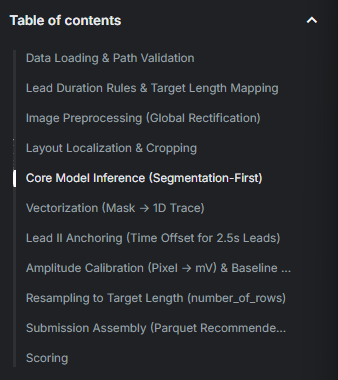
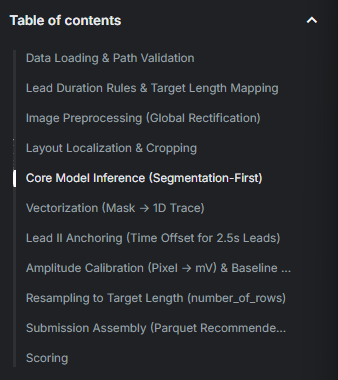
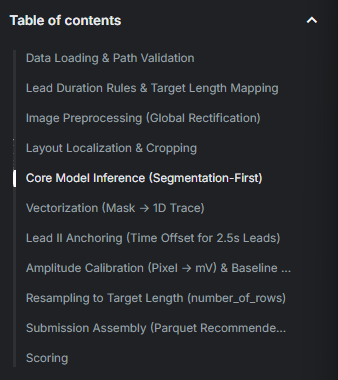
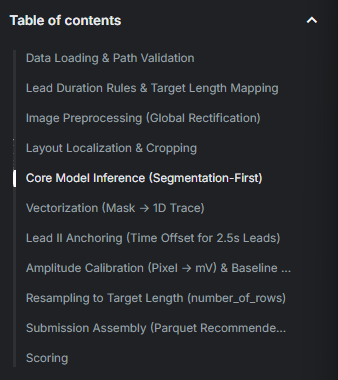

In [ ]:
# ============================================================
# STAGE 5.1 — Mini Training (Smoke Test Segmentation) (ONE CELL, Kaggle-ready) — REVISI FULL (WITH TRAIN INDICATORS)
#
# Upgrade monitoring:
# - Progress bar per-epoch (tqdm) + running loss
# - Log per batch (interval) : loss_total, loss_bce, loss_dice, dice_score, lr, speed
# - Mini validation split (by base_id) + best checkpoint saving
# - Save training log CSV: /kaggle/working/seg_smoke_log.csv
# ============================================================

import os, json, math, time, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFile, ImageFilter
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Progress bar (fallback aman kalau tqdm tidak ada)
try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False
    tqdm = None

# ----------------------------
# 0) Require STAGE 1
# ----------------------------
for need in ["PATHS", "df_train_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")

# ----------------------------
# 1) Config (smoke-test; kecil & cepat)
# ----------------------------
SMOKE_CFG = {
    "seed": 2026,
    "n_train_ids": 12,            # jumlah record train untuk smoke test (total)
    "n_val_ids": 2,               # dari n_train_ids, sisihkan untuk validasi
    "variant_pick": "0001",       # pilih varian tertentu jika ada; fallback ke pertama
    "keys": ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6","II_rhythm"],
    "img_size": 256,              # resize crop -> 256x256
    "batch_size": 8,
    "epochs": 3,
    "lr": 2e-3,
    "weight_decay": 0.0,
    "num_workers": 0,             # Kaggle aman 0 (lebih stabil)
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # monitoring
    "log_interval": 5,            # print setiap N batch (untuk dataset kecil)
    "use_amp": True,              # mixed precision jika CUDA tersedia
    "grad_clip": 0.0,             # 0=off

    # pseudo-label params
    "pseudo_bg_blur": 7.0,
    "pseudo_pctl": 99.5,
    "pseudo_thr": 0.25,
    "pseudo_smooth": True,
    "pseudo_smooth_radius": 1.0,

    # saving
    "ckpt_path": "/kaggle/working/seg_smoke.pt",          # latest
    "best_ckpt_path": "/kaggle/working/seg_smoke_best.pt",
    "ts_path": "/kaggle/working/seg_model.ts",
    "cfg_path": "/kaggle/working/seg_smoke_config.json",
    "log_csv": "/kaggle/working/seg_smoke_log.csv",
}

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SMOKE_CFG["seed"])

device = torch.device(SMOKE_CFG["device"])
use_amp = bool(SMOKE_CFG["use_amp"]) and (device.type == "cuda")

print("=== SMOKE TRAIN CONFIG ===")
print("device:", device, "| amp:", use_amp)
print("n_train_ids(total):", SMOKE_CFG["n_train_ids"], "| n_val_ids:", SMOKE_CFG["n_val_ids"])
print("img_size:", SMOKE_CFG["img_size"], "| epochs:", SMOKE_CFG["epochs"], "| bs:", SMOKE_CFG["batch_size"])

# ----------------------------
# 2) Helpers: paths + RGBA->RGB
# ----------------------------
def train_record_dir(base_id: str) -> Path:
    return Path(PATHS["TRAIN_DIR"]) / str(base_id)

def train_image_paths(base_id: str):
    d = train_record_dir(base_id)
    if not d.exists():
        return []
    return sorted(d.glob(f"{base_id}-*.png"))

def _rgba_to_rgb_white(rgba: np.ndarray) -> np.ndarray:
    if rgba.shape[2] == 3:
        return rgba.astype(np.uint8)
    rgb = rgba[:, :, :3].astype(np.float32)
    a = rgba[:, :, 3:4].astype(np.float32) / 255.0
    out = rgb * a + 255.0 * (1.0 - a)
    return np.clip(out, 0, 255).astype(np.uint8)

def load_png_rgb(path: Path) -> np.ndarray:
    with Image.open(path) as im:
        im = im.convert("RGBA")
        rgba = np.array(im, dtype=np.uint8)
    return _rgba_to_rgb_white(rgba)

# ----------------------------
# 3) Layout crop (fallback jika fungsi STAGE 4 tidak ada)
# ----------------------------
LEAD_GRID_ORDER = [
    ["I",   "aVR", "V1", "V4"],
    ["II",  "aVL", "V2", "V5"],
    ["III", "aVF", "V3", "V6"],
]

LAYOUT_FALLBACK = {
    "use_content_bbox": True,
    "white_thr": 245,
    "min_content_frac": 0.05,
    "x_left_frac": 0.03,
    "x_right_frac": 0.97,
    "grid_top_frac": 0.08,
    "grid_bottom_frac": 0.78,
    "rhythm_top_frac": 0.78,
    "rhythm_bottom_frac": 0.97,
    "cell_pad_x_frac": 0.015,
    "cell_pad_y_frac": 0.06,
    "rhythm_pad_x_frac": 0.01,
    "rhythm_pad_y_frac": 0.08,
}

def _content_bbox(rgb: np.ndarray, cfg: dict):
    h, w = rgb.shape[:2]
    if not cfg.get("use_content_bbox", True):
        return (0, 0, w, h)
    thr = int(cfg.get("white_thr", 245))
    nonwhite = (rgb[:, :, 0] < thr) | (rgb[:, :, 1] < thr) | (rgb[:, :, 2] < thr)
    ys, xs = np.where(nonwhite)
    if len(xs) == 0:
        return (0, 0, w, h)
    x0, x1 = int(xs.min()), int(xs.max()) + 1
    y0, y1 = int(ys.min()), int(ys.max()) + 1
    area = (x1 - x0) * (y1 - y0)
    if area < cfg.get("min_content_frac", 0.05) * (w * h):
        return (0, 0, w, h)
    pad = int(0.01 * max(w, h))
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(w, x1 + pad); y1 = min(h, y1 + pad)
    return (x0, y0, x1, y1)

def _clip_box(box, w, h):
    x0, y0, x1, y1 = box
    x0 = int(max(0, min(w-1, x0)))
    y0 = int(max(0, min(h-1, y0)))
    x1 = int(max(x0+1, min(w, x1)))
    y1 = int(max(y0+1, min(h, y1)))
    return (x0, y0, x1, y1)

def make_layout_boxes(rgb: np.ndarray, cfg: dict):
    h, w = rgb.shape[:2]
    cx0, cy0, cx1, cy1 = _content_bbox(rgb, cfg)
    cw, ch = (cx1 - cx0), (cy1 - cy0)

    xl = cx0 + int(cfg["x_left_frac"]  * cw)
    xr = cx0 + int(cfg["x_right_frac"] * cw)

    grid_top = cy0 + int(cfg["grid_top_frac"] * ch)
    grid_bot = cy0 + int(cfg["grid_bottom_frac"] * ch)

    rhy_top  = cy0 + int(cfg["rhythm_top_frac"] * ch)
    rhy_bot  = cy0 + int(cfg["rhythm_bottom_frac"] * ch)

    rows, cols = 3, 4
    grid_h = max(1, grid_bot - grid_top)
    grid_w = max(1, xr - xl)
    cell_h = grid_h / rows
    cell_w = grid_w / cols

    pad_x = cfg["cell_pad_x_frac"] * cell_w
    pad_y = cfg["cell_pad_y_frac"] * cell_h

    boxes = {}
    for r in range(rows):
        for c in range(cols):
            lead = LEAD_GRID_ORDER[r][c]
            x0 = xl + int(round(c * cell_w + pad_x))
            x1 = xl + int(round((c + 1) * cell_w - pad_x))
            y0 = grid_top + int(round(r * cell_h + pad_y))
            y1 = grid_top + int(round((r + 1) * cell_h - pad_y))
            boxes[lead] = _clip_box((x0, y0, x1, y1), w, h)

    rpad_x = int(cfg["rhythm_pad_x_frac"] * grid_w)
    rpad_y = int(cfg["rhythm_pad_y_frac"] * max(1, (rhy_bot - rhy_top)))
    rx0 = xl + rpad_x
    rx1 = xr - rpad_x
    ry0 = rhy_top + rpad_y
    ry1 = rhy_bot - rpad_y
    boxes["II_rhythm"] = _clip_box((rx0, ry0, rx1, ry1), w, h)

    return boxes

def crop_by_key(rgb: np.ndarray, key: str) -> np.ndarray:
    # gunakan layout STAGE 4 jika tersedia
    if "_make_layout_boxes" in globals() and "LAYOUT_CFG" in globals():
        _, boxes = _make_layout_boxes(rgb, LAYOUT_CFG)
    else:
        boxes = make_layout_boxes(rgb, LAYOUT_FALLBACK)

    if key not in boxes:
        raise KeyError(f"Key crop `{key}` not in boxes. Available: {list(boxes.keys())}")
    x0, y0, x1, y1 = boxes[key]
    return rgb[y0:y1, x0:x1]

# ----------------------------
# 4) Pseudo-label generator (heuristic prob -> binary mask)
# ----------------------------
def pseudo_prob_from_crop(rgb_u8: np.ndarray, cfg: dict) -> np.ndarray:
    gray = np.array(Image.fromarray(rgb_u8).convert("L"), dtype=np.uint8)
    im = Image.fromarray(gray)

    # background blur
    im_blur = im.filter(ImageFilter.GaussianBlur(radius=float(cfg["pseudo_bg_blur"])))
    bg = np.array(im_blur, dtype=np.float32)
    g = gray.astype(np.float32)

    enh = bg - g
    enh[enh < 0] = 0.0

    denom = float(np.percentile(enh, float(cfg["pseudo_pctl"]))) + 1e-6
    prob = np.clip(enh / denom, 0.0, 1.0).astype(np.float32)

    if cfg.get("pseudo_smooth", True):
        pim = Image.fromarray((prob * 255).astype(np.uint8))
        pim = pim.filter(ImageFilter.GaussianBlur(radius=float(cfg["pseudo_smooth_radius"])))
        prob = (np.array(pim, dtype=np.float32) / 255.0)

    return np.clip(prob, 0.0, 1.0).astype(np.float32)

def pseudo_mask_from_prob(prob: np.ndarray, thr: float) -> np.ndarray:
    return (prob >= float(thr)).astype(np.float32)

# ----------------------------
# 5) Dataset
# ----------------------------
class CropSegDataset(Dataset):
    def __init__(self, items, cfg):
        self.items = items
        self.cfg = cfg
        self.size = int(cfg["img_size"])

    def __len__(self):
        return len(self.items)

    def _resize(self, arr: np.ndarray, size: int, is_mask: bool):
        im = Image.fromarray(arr)
        if is_mask:
            im = im.resize((size, size), resample=Image.NEAREST)
        else:
            im = im.resize((size, size), resample=Image.BILINEAR)
        return np.array(im)

    def __getitem__(self, idx):
        base_id, key, img_path = self.items[idx]
        rgb = load_png_rgb(img_path)
        crop = crop_by_key(rgb, key)

        prob = pseudo_prob_from_crop(crop, self.cfg)
        mask = pseudo_mask_from_prob(prob, self.cfg["pseudo_thr"])

        crop_rs = self._resize(crop, self.size, is_mask=False)
        mask_rs = self._resize((mask * 255).astype(np.uint8), self.size, is_mask=True)
        mask_rs = (mask_rs.astype(np.float32) / 255.0)

        x = torch.from_numpy(crop_rs).permute(2, 0, 1).float() / 255.0  # 3xHxW
        y = torch.from_numpy(mask_rs).unsqueeze(0).float()              # 1xHxW

        return x, y, str(base_id), str(key)

# ----------------------------
# 6) Tiny U-Net (smoke)
# ----------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class TinyUNet(nn.Module):
    def __init__(self, base=16):
        super().__init__()
        self.enc1 = ConvBNReLU(3, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBNReLU(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.bott = ConvBNReLU(base*2, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = ConvBNReLU(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = ConvBNReLU(base*2, base)
        self.head = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bott(self.pool2(e2))
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.head(d1)

def dice_loss_with_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    return (1.0 - (num / den)).mean()

@torch.no_grad()
def dice_score_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs >= thr).float()
    num = 2.0 * (pred * targets).sum(dim=(2,3))
    den = (pred + targets).sum(dim=(2,3)) + eps
    return (num / den).mean().item()

# ----------------------------
# 7) Build smoke items (split by base_id)
# ----------------------------
train_ids_all = df_train_meta["id"].astype(str).unique().tolist()
if len(train_ids_all) == 0:
    raise RuntimeError("No train ids found in df_train_meta.")

rng = np.random.RandomState(SMOKE_CFG["seed"])
pick_ids = train_ids_all if len(train_ids_all) <= SMOKE_CFG["n_train_ids"] else rng.choice(
    train_ids_all, size=SMOKE_CFG["n_train_ids"], replace=False
).tolist()

rng.shuffle(pick_ids)
n_val_ids = max(0, min(int(SMOKE_CFG["n_val_ids"]), len(pick_ids) - 1))  # at least 1 train id
val_ids = pick_ids[:n_val_ids]
tr_ids  = pick_ids[n_val_ids:]

def pick_variant_image(tid: str) -> Path:
    imgs = train_image_paths(tid)
    if not imgs:
        return None
    want = f"-{SMOKE_CFG['variant_pick']}.png"
    for p in imgs:
        if p.name.endswith(want):
            return p
    return imgs[0]

def build_items(id_list):
    items = []
    missing = 0
    for tid in id_list:
        p = pick_variant_image(tid)
        if p is None:
            missing += 1
            continue
        for key in SMOKE_CFG["keys"]:
            items.append((tid, key, p))
    return items, missing

train_items, miss_tr = build_items(tr_ids)
val_items, miss_va = build_items(val_ids)

print("\n=== SMOKE SPLIT ===")
print("picked total ids:", len(pick_ids))
print("train ids:", len(tr_ids), "| val ids:", len(val_ids))
print("missing train imgs:", miss_tr, "| missing val imgs:", miss_va)
print("train samples:", len(train_items), "| val samples:", len(val_items))

if len(train_items) == 0:
    raise RuntimeError("No training samples built. Check train_image_paths().")

ds_tr = CropSegDataset(train_items, SMOKE_CFG)
dl_tr = DataLoader(
    ds_tr,
    batch_size=int(SMOKE_CFG["batch_size"]),
    shuffle=True,
    num_workers=int(SMOKE_CFG["num_workers"]),
    pin_memory=(device.type=="cuda"),
)

dl_va = None
if len(val_items) > 0:
    ds_va = CropSegDataset(val_items, SMOKE_CFG)
    dl_va = DataLoader(
        ds_va,
        batch_size=int(SMOKE_CFG["batch_size"]),
        shuffle=False,
        num_workers=0,
        pin_memory=(device.type=="cuda"),
    )

# ----------------------------
# 8) Train loop (with indicators)
# ----------------------------
model = TinyUNet(base=16).to(device)
opt = torch.optim.Adam(model.parameters(), lr=float(SMOKE_CFG["lr"]), weight_decay=float(SMOKE_CFG["weight_decay"]))
bce = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def get_lr(optimizer):
    return float(optimizer.param_groups[0]["lr"])

log_rows = []
best_val = float("inf")

print("\n=== TRAIN SMOKE (WITH MONITORING) ===")
t_global = time.time()

for epoch in range(1, int(SMOKE_CFG["epochs"]) + 1):
    model.train()
    t_epoch = time.time()

    run_loss = 0.0
    run_bce  = 0.0
    run_dice = 0.0
    run_ds   = 0.0
    n_seen   = 0

    it = dl_tr
    if _HAS_TQDM:
        it = tqdm(dl_tr, desc=f"epoch {epoch}/{SMOKE_CFG['epochs']}", leave=False)

    for step, (xb, yb, _, _) in enumerate(it, start=1):
        t_step = time.time()

        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
            loss_bce = bce(logits, yb)
            loss_dice = dice_loss_with_logits(logits, yb)
            loss = 0.7 * loss_bce + 0.3 * loss_dice

        scaler.scale(loss).backward()
        if float(SMOKE_CFG["grad_clip"]) > 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), float(SMOKE_CFG["grad_clip"]))
        scaler.step(opt)
        scaler.update()

        bs = int(xb.size(0))
        n_seen += bs

        loss_v = float(loss.detach().cpu().item())
        bce_v  = float(loss_bce.detach().cpu().item())
        dice_v = float(loss_dice.detach().cpu().item())

        ds_v = dice_score_from_logits(logits.detach(), yb.detach(), thr=0.5)

        run_loss += loss_v * bs
        run_bce  += bce_v  * bs
        run_dice += dice_v * bs
        run_ds   += ds_v   * bs

        avg_loss = run_loss / max(1, n_seen)
        avg_bce  = run_bce  / max(1, n_seen)
        avg_dice = run_dice / max(1, n_seen)
        avg_ds   = run_ds   / max(1, n_seen)

        step_time = time.time() - t_step
        ips = bs / max(1e-6, step_time)

        if _HAS_TQDM:
            it.set_postfix({
                "loss": f"{avg_loss:.4f}",
                "bce": f"{avg_bce:.4f}",
                "diceL": f"{avg_dice:.4f}",
                "diceS": f"{avg_ds:.3f}",
                "lr": f"{get_lr(opt):.2e}",
            })

        if (step % int(SMOKE_CFG["log_interval"]) == 0) or (step == 1) or (step == len(dl_tr)):
            mem = ""
            if device.type == "cuda":
                mem_mb = torch.cuda.max_memory_allocated() / (1024**2)
                mem = f" | gpu_mem(MB)={mem_mb:.0f}"
            print(
                f"epoch {epoch} | step {step:03d}/{len(dl_tr)}"
                f" | loss={avg_loss:.4f} (bce={avg_bce:.4f}, diceL={avg_dice:.4f})"
                f" | diceS={avg_ds:.3f}"
                f" | lr={get_lr(opt):.2e}"
                f" | {ips:.1f} samples/s{mem}"
            )

        log_rows.append({
            "split": "train",
            "epoch": epoch,
            "step": step,
            "loss": loss_v,
            "loss_bce": bce_v,
            "loss_dice": dice_v,
            "dice_score": ds_v,
            "lr": get_lr(opt),
            "batch_size": bs,
        })

    # ----- validation -----
    val_loss = None
    val_ds = None
    if dl_va is not None:
        model.eval()
        v_loss_sum = 0.0
        v_ds_sum = 0.0
        v_n = 0

        itv = dl_va
        if _HAS_TQDM:
            itv = tqdm(dl_va, desc=f"val {epoch}", leave=False)

        with torch.no_grad():
            for stepv, (xb, yb, _, _) in enumerate(itv, start=1):
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=use_amp):
                    logits = model(xb)
                    loss_bce = bce(logits, yb)
                    loss_dice = dice_loss_with_logits(logits, yb)
                    loss = 0.7 * loss_bce + 0.3 * loss_dice

                bs = int(xb.size(0))
                v_n += bs
                v_loss_sum += float(loss.detach().cpu().item()) * bs
                v_ds_sum += float(dice_score_from_logits(logits, yb, thr=0.5)) * bs

        val_loss = v_loss_sum / max(1, v_n)
        val_ds = v_ds_sum / max(1, v_n)

        print(f"epoch {epoch} | VAL | loss={val_loss:.4f} | diceS={val_ds:.3f}")

        log_rows.append({
            "split": "val",
            "epoch": epoch,
            "step": 0,
            "loss": float(val_loss),
            "loss_bce": np.nan,
            "loss_dice": np.nan,
            "dice_score": float(val_ds),
            "lr": get_lr(opt),
            "batch_size": v_n,
        })

    # ----- checkpoint (latest + best by val loss if available) -----
    ckpt = {
        "model_state": model.state_dict(),
        "cfg": SMOKE_CFG,
        "layout_cfg_used": (LAYOUT_CFG if "LAYOUT_CFG" in globals() else LAYOUT_FALLBACK),
        "epoch": epoch,
        "val_loss": float(val_loss) if val_loss is not None else None,
        "val_dice_score": float(val_ds) if val_ds is not None else None,
    }
    torch.save(ckpt, SMOKE_CFG["ckpt_path"])

    improved = False
    if val_loss is not None:
        if val_loss < best_val:
            best_val = float(val_loss)
            torch.save(ckpt, SMOKE_CFG["best_ckpt_path"])
            improved = True

    t_ep = time.time() - t_epoch
    msg_best = " | best_saved" if improved else ""
    print(f"epoch {epoch} done | epoch_time_sec={t_ep:.2f}{msg_best}")

t_total = time.time() - t_global
print("\ntrain_total_time_sec:", round(t_total, 2))

# ----------------------------
# 9) Save TorchScript (use best if exists else latest)
# ----------------------------
best_path = Path(SMOKE_CFG["best_ckpt_path"])
ckpt_path = Path(SMOKE_CFG["ckpt_path"])
ts_path = Path(SMOKE_CFG["ts_path"])

use_ckpt = best_path if best_path.exists() else ckpt_path
state = torch.load(use_ckpt, map_location=device)
model.load_state_dict(state["model_state"])
model.eval()

example = torch.rand(1, 3, SMOKE_CFG["img_size"], SMOKE_CFG["img_size"], device=device)
with torch.no_grad():
    traced = torch.jit.trace(model, example)
traced.save(str(ts_path))

print("\nSaved latest ckpt :", SMOKE_CFG["ckpt_path"])
if best_path.exists():
    print("Saved best ckpt   :", SMOKE_CFG["best_ckpt_path"], "| best_val_loss:", best_val)
print("Saved TorchScript :", str(ts_path))

# Save config + logs
Path(SMOKE_CFG["cfg_path"]).write_text(json.dumps(SMOKE_CFG, indent=2, sort_keys=True))
df_log = pd.DataFrame(log_rows)
df_log.to_csv(SMOKE_CFG["log_csv"], index=False)

print("Saved config      :", SMOKE_CFG["cfg_path"])
print("Saved train log   :", SMOKE_CFG["log_csv"])
print("\n[OK] Mini Training done. Untuk inference TorchScript, arahkan ke:", str(ts_path))


# Final Training (Full CV Segmentation + Checkpointing)

In [ ]:
# ============================================================
# STAGE 5.2 — Final Training (Full CV Segmentation + Checkpointing) (ONE CELL, Kaggle-ready) — REVISI FULL (WITH MONITORING)
#
# Revisi utama (monitoring + robustness):
# - tqdm progress bar + running metrics
# - per-batch log interval (loss/bce/dice, dice_score, lr, speed, gpu_mem)
# - early stop optional (patience)
# - save: fold_{k}_best.pt, fold_{k}_last.pt, fold_{k}.ts
# - save log CSV per fold + summary JSON
#
# Catatan:
# - Mask = PSEUDO-LABEL heuristic (bukan GT mask).
# ============================================================

import os, json, math, time, random, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFile, ImageFilter
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupKFold

try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    tqdm = None
    _HAS_TQDM = False

# ----------------------------
# 0) Require STAGE 1
# ----------------------------
for need in ["PATHS", "df_train_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")

# ----------------------------
# 1) Config (tuning knobs)
# ----------------------------
FT_CFG = {
    "seed": 2026,

    # CV
    "n_splits": 5,                 # GroupKFold by base_id
    "folds_to_run": None,          # None=all, atau list mis. [0,1] untuk cepat

    # Data
    "use_all_variants": True,      # True: pakai semua <id>-*.png ; False: pakai hanya -0001 jika ada
    "prefer_variant": "0001",      # kalau use_all_variants=False, coba ambil ini
    "keys": ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6","II_rhythm"],

    # Train size
    "img_size": 256,
    "batch_size": 16,
    "epochs": 8,
    "lr": 2e-3,
    "weight_decay": 1e-4,
    "num_workers": 2,
    "pin_memory": True,
    "drop_last": True,

    # Monitoring
    "log_interval": 50,            # print setiap N batch
    "use_tqdm": True,
    "early_stop_patience": 0,      # 0=off, mis. 2 -> stop jika val_loss tidak membaik 2 epoch
    "save_every_epoch": False,     # kalau True: simpan fold_{k}_e{epoch}.pt (bisa besar)

    # Augment (ringan, aman untuk ECG)
    "aug_enable": True,
    "aug_brightness": 0.10,
    "aug_contrast": 0.10,
    "aug_gauss_noise": 0.01,
    "aug_small_rotate_deg": 2.0,

    # Pseudo label
    "pseudo_bg_blur": 7.0,
    "pseudo_pctl": 99.5,
    "pseudo_thr": 0.25,
    "pseudo_smooth": True,
    "pseudo_smooth_radius": 1.0,

    # Model
    "unet_base": 24,
    "loss_bce_w": 0.7,
    "loss_dice_w": 0.3,

    # Mixed precision
    "amp": True,
    "grad_clip": 0.0,              # 0=off

    # Saving
    "out_root": "/kaggle/working/physionet_ecg_cache/models/seg_final",
    "export_best_torchscript": True,
    "also_copy_fold0_to_seg_model_ts": True,
}

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(int(FT_CFG["seed"]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = bool(FT_CFG["amp"]) and (device.type == "cuda")

print("=== FINAL TRAIN CONFIG ===")
print("device:", device, "| amp:", use_amp)
print("n_splits:", FT_CFG["n_splits"], "| epochs:", FT_CFG["epochs"], "| img_size:", FT_CFG["img_size"])

_cfg_id = hashlib.md5(json.dumps(FT_CFG, sort_keys=True).encode("utf-8")).hexdigest()[:12]
OUT_DIR = Path(FT_CFG["out_root"]) / f"cfg_{_cfg_id}"
OUT_DIR.mkdir(parents=True, exist_ok=True)
(Path(OUT_DIR) / "training_config.json").write_text(json.dumps(FT_CFG, indent=2, sort_keys=True))
print("OUT_DIR:", str(OUT_DIR))

# ----------------------------
# 2) Helpers: paths + RGBA->RGB
# ----------------------------
def train_record_dir(base_id: str) -> Path:
    return Path(PATHS["TRAIN_DIR"]) / str(base_id)

def train_image_paths(base_id: str):
    d = train_record_dir(base_id)
    if not d.exists():
        return []
    return sorted(d.glob(f"{base_id}-*.png"))

def _rgba_to_rgb_white(rgba: np.ndarray) -> np.ndarray:
    if rgba.ndim != 3 or rgba.shape[2] not in (3, 4):
        raise ValueError(f"Expected HxWx3/4, got {rgba.shape}")
    if rgba.shape[2] == 3:
        return rgba.astype(np.uint8)
    rgb = rgba[:, :, :3].astype(np.float32)
    a = rgba[:, :, 3:4].astype(np.float32) / 255.0
    out = rgb * a + 255.0 * (1.0 - a)
    return np.clip(out, 0, 255).astype(np.uint8)

def load_png_rgb(path: Path) -> np.ndarray:
    with Image.open(path) as im:
        im = im.convert("RGBA")
        rgba = np.array(im, dtype=np.uint8)
    return _rgba_to_rgb_white(rgba)

# ----------------------------
# 3) Layout crop (STAGE 4 preferred, fallback if not)
# ----------------------------
LEAD_GRID_ORDER = [
    ["I",   "aVR", "V1", "V4"],
    ["II",  "aVL", "V2", "V5"],
    ["III", "aVF", "V3", "V6"],
]

LAYOUT_FALLBACK = {
    "use_content_bbox": True,
    "white_thr": 245,
    "min_content_frac": 0.05,
    "x_left_frac": 0.03,
    "x_right_frac": 0.97,
    "grid_top_frac": 0.08,
    "grid_bottom_frac": 0.78,
    "rhythm_top_frac": 0.78,
    "rhythm_bottom_frac": 0.97,
    "cell_pad_x_frac": 0.015,
    "cell_pad_y_frac": 0.06,
    "rhythm_pad_x_frac": 0.01,
    "rhythm_pad_y_frac": 0.08,
}

def _content_bbox(rgb: np.ndarray, cfg: dict):
    h, w = rgb.shape[:2]
    if not cfg.get("use_content_bbox", True):
        return (0, 0, w, h)
    thr = int(cfg.get("white_thr", 245))
    nonwhite = (rgb[:, :, 0] < thr) | (rgb[:, :, 1] < thr) | (rgb[:, :, 2] < thr)
    ys, xs = np.where(nonwhite)
    if len(xs) == 0:
        return (0, 0, w, h)
    x0, x1 = int(xs.min()), int(xs.max()) + 1
    y0, y1 = int(ys.min()), int(ys.max()) + 1
    area = (x1 - x0) * (y1 - y0)
    if area < cfg.get("min_content_frac", 0.05) * (w * h):
        return (0, 0, w, h)
    pad = int(0.01 * max(w, h))
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(w, x1 + pad); y1 = min(h, y1 + pad)
    return (x0, y0, x1, y1)

def _clip_box(box, w, h):
    x0, y0, x1, y1 = box
    x0 = int(max(0, min(w-1, x0)))
    y0 = int(max(0, min(h-1, y0)))
    x1 = int(max(x0+1, min(w, x1)))
    y1 = int(max(y0+1, min(h, y1)))
    return (x0, y0, x1, y1)

def make_layout_boxes_fallback(rgb: np.ndarray, cfg: dict):
    h, w = rgb.shape[:2]
    cx0, cy0, cx1, cy1 = _content_bbox(rgb, cfg)
    cw, ch = (cx1 - cx0), (cy1 - cy0)

    xl = cx0 + int(cfg["x_left_frac"]  * cw)
    xr = cx0 + int(cfg["x_right_frac"] * cw)

    grid_top = cy0 + int(cfg["grid_top_frac"] * ch)
    grid_bot = cy0 + int(cfg["grid_bottom_frac"] * ch)

    rhy_top  = cy0 + int(cfg["rhythm_top_frac"] * ch)
    rhy_bot  = cy0 + int(cfg["rhythm_bottom_frac"] * ch)

    rows, cols = 3, 4
    grid_h = max(1, grid_bot - grid_top)
    grid_w = max(1, xr - xl)
    cell_h = grid_h / rows
    cell_w = grid_w / cols

    pad_x = cfg["cell_pad_x_frac"] * cell_w
    pad_y = cfg["cell_pad_y_frac"] * cell_h

    boxes = {}
    for r in range(rows):
        for c in range(cols):
            lead = LEAD_GRID_ORDER[r][c]
            x0 = xl + int(round(c * cell_w + pad_x))
            x1 = xl + int(round((c + 1) * cell_w - pad_x))
            y0 = grid_top + int(round(r * cell_h + pad_y))
            y1 = grid_top + int(round((r + 1) * cell_h - pad_y))
            boxes[lead] = _clip_box((x0, y0, x1, y1), w, h)

    rpad_x = int(cfg["rhythm_pad_x_frac"] * grid_w)
    rpad_y = int(cfg["rhythm_pad_y_frac"] * max(1, (rhy_bot - rhy_top)))
    rx0 = xl + rpad_x
    rx1 = xr - rpad_x
    ry0 = rhy_top + rpad_y
    ry1 = rhy_bot - rpad_y
    boxes["II_rhythm"] = _clip_box((rx0, ry0, rx1, ry1), w, h)

    return boxes

def crop_by_key(rgb: np.ndarray, key: str) -> np.ndarray:
    if "_make_layout_boxes" in globals() and "LAYOUT_CFG" in globals():
        _, boxes = _make_layout_boxes(rgb, LAYOUT_CFG)
    else:
        boxes = make_layout_boxes_fallback(rgb, LAYOUT_FALLBACK)
    if key not in boxes:
        raise KeyError(f"Key `{key}` not in boxes. Available: {list(boxes.keys())}")
    x0, y0, x1, y1 = boxes[key]
    return rgb[y0:y1, x0:x1]

# ----------------------------
# 4) Pseudo-label generator (heuristic)
# ----------------------------
def pseudo_prob_from_crop(rgb_u8: np.ndarray, cfg: dict) -> np.ndarray:
    gray = np.array(Image.fromarray(rgb_u8).convert("L"), dtype=np.uint8)
    im = Image.fromarray(gray)
    im_blur = im.filter(ImageFilter.GaussianBlur(radius=float(cfg["pseudo_bg_blur"])))
    bg = np.array(im_blur, dtype=np.float32)
    g = gray.astype(np.float32)

    enh = bg - g
    enh[enh < 0] = 0.0
    denom = float(np.percentile(enh, float(cfg["pseudo_pctl"]))) + 1e-6
    prob = np.clip(enh / denom, 0.0, 1.0).astype(np.float32)

    if cfg.get("pseudo_smooth", True):
        pim = Image.fromarray((prob * 255).astype(np.uint8))
        pim = pim.filter(ImageFilter.GaussianBlur(radius=float(cfg["pseudo_smooth_radius"])))
        prob = (np.array(pim, dtype=np.float32) / 255.0)

    return np.clip(prob, 0.0, 1.0).astype(np.float32)

def pseudo_mask_from_prob(prob: np.ndarray, thr: float) -> np.ndarray:
    return (prob >= float(thr)).astype(np.float32)

# ----------------------------
# 5) Augment (image only; label derived after aug)
# ----------------------------
def _rand_uniform(a, b):
    return a + (b - a) * random.random()

def aug_image_rgb(rgb_u8: np.ndarray, cfg: dict) -> np.ndarray:
    if not cfg.get("aug_enable", True):
        return rgb_u8

    im = Image.fromarray(rgb_u8)

    deg = float(cfg.get("aug_small_rotate_deg", 0.0))
    if deg > 0:
        ang = _rand_uniform(-deg, deg)
        im = im.rotate(ang, resample=Image.BILINEAR, expand=False, fillcolor=(255, 255, 255))

    arr = np.array(im, dtype=np.float32)

    b = float(cfg.get("aug_brightness", 0.0))
    if b > 0:
        factor = _rand_uniform(1.0 - b, 1.0 + b)
        arr = arr * factor

    c = float(cfg.get("aug_contrast", 0.0))
    if c > 0:
        factor = _rand_uniform(1.0 - c, 1.0 + c)
        mean = arr.mean(axis=(0,1), keepdims=True)
        arr = (arr - mean) * factor + mean

    gn = float(cfg.get("aug_gauss_noise", 0.0))
    if gn > 0:
        arr = arr + np.random.normal(0.0, gn * 255.0, size=arr.shape).astype(np.float32)

    arr = np.clip(arr, 0, 255).astype(np.uint8)
    return arr

# ----------------------------
# 6) Dataset
# ----------------------------
class SegTrainDataset(Dataset):
    def __init__(self, samples, cfg, aug: bool):
        self.samples = samples
        self.cfg = cfg
        self.size = int(cfg["img_size"])
        self.aug = bool(aug)

    def __len__(self):
        return len(self.samples)

    def _resize_rgb(self, rgb: np.ndarray) -> np.ndarray:
        return np.array(Image.fromarray(rgb).resize((self.size, self.size), resample=Image.BILINEAR), dtype=np.uint8)

    def _resize_mask(self, mask01: np.ndarray) -> np.ndarray:
        m = (mask01 * 255).astype(np.uint8)
        m = Image.fromarray(m).resize((self.size, self.size), resample=Image.NEAREST)
        return (np.array(m, dtype=np.float32) / 255.0)

    def __getitem__(self, idx):
        base_id, img_path, key = self.samples[idx]
        rgb = load_png_rgb(img_path)
        crop = crop_by_key(rgb, key)

        if self.aug:
            crop = aug_image_rgb(crop, self.cfg)

        prob = pseudo_prob_from_crop(crop, self.cfg)
        mask = pseudo_mask_from_prob(prob, self.cfg["pseudo_thr"])

        crop = self._resize_rgb(crop)
        mask = self._resize_mask(mask)

        x = torch.from_numpy(crop).permute(2,0,1).float() / 255.0
        y = torch.from_numpy(mask).unsqueeze(0).float()
        return x, y

# ----------------------------
# 7) Model (U-Net moderate)
# ----------------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, base=24):
        super().__init__()
        b = int(base)
        self.e1 = ConvBNReLU(3, b)
        self.p1 = nn.MaxPool2d(2)
        self.e2 = ConvBNReLU(b, b*2)
        self.p2 = nn.MaxPool2d(2)
        self.e3 = ConvBNReLU(b*2, b*4)
        self.p3 = nn.MaxPool2d(2)
        self.bt = ConvBNReLU(b*4, b*8)

        self.u3 = nn.ConvTranspose2d(b*8, b*4, 2, stride=2)
        self.d3 = ConvBNReLU(b*8, b*4)
        self.u2 = nn.ConvTranspose2d(b*4, b*2, 2, stride=2)
        self.d2 = ConvBNReLU(b*4, b*2)
        self.u1 = nn.ConvTranspose2d(b*2, b, 2, stride=2)
        self.d1 = ConvBNReLU(b*2, b)
        self.head = nn.Conv2d(b, 1, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        e3 = self.e3(self.p2(e2))
        bt = self.bt(self.p3(e3))

        x = self.u3(bt); x = torch.cat([x, e3], dim=1); x = self.d3(x)
        x = self.u2(x);  x = torch.cat([x, e2], dim=1); x = self.d2(x)
        x = self.u1(x);  x = torch.cat([x, e1], dim=1); x = self.d1(x)
        return self.head(x)

def dice_loss_with_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    return (1.0 - (num / den)).mean()

@torch.no_grad()
def dice_score_with_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs >= thr).float()
    num = 2.0 * (pred * targets).sum(dim=(2,3))
    den = (pred + targets).sum(dim=(2,3)) + eps
    return (num / den).mean().item()

# ----------------------------
# 8) Build samples (per id -> images -> keys)
# ----------------------------
all_ids = df_train_meta["id"].astype(str).unique().tolist()

def pick_images_for_id(tid: str, cfg: dict):
    imgs = train_image_paths(tid)
    if not imgs:
        return []
    if cfg["use_all_variants"]:
        return imgs
    want = f"-{cfg['prefer_variant']}.png"
    for p in imgs:
        if p.name.endswith(want):
            return [p]
    return [imgs[0]]

id_to_imgs = {tid: pick_images_for_id(tid, FT_CFG) for tid in all_ids}
all_ids = [tid for tid in all_ids if len(id_to_imgs.get(tid, [])) > 0]
print("train ids with images:", len(all_ids))

gkf = GroupKFold(n_splits=int(FT_CFG["n_splits"]))
folds = []
for fold, (tr_idx, va_idx) in enumerate(gkf.split(all_ids, groups=all_ids)):
    tr_ids = [all_ids[i] for i in tr_idx]
    va_ids = [all_ids[i] for i in va_idx]
    folds.append({"fold": fold, "train_ids": tr_ids, "val_ids": va_ids})

(Path(OUT_DIR) / "folds.json").write_text(json.dumps(
    [{"fold": f["fold"], "n_train_ids": len(f["train_ids"]), "n_val_ids": len(f["val_ids"])} for f in folds],
    indent=2, sort_keys=True
))

folds_to_run = FT_CFG["folds_to_run"]
if folds_to_run is None:
    folds_to_run = [f["fold"] for f in folds]
else:
    folds_to_run = [int(x) for x in folds_to_run]
print("folds_to_run:", folds_to_run)

def build_samples_for_ids(id_list, cfg):
    samples = []
    keys = cfg["keys"]
    for tid in id_list:
        imgs = id_to_imgs.get(tid, [])
        for p in imgs:
            for k in keys:
                samples.append((tid, p, k))
    return samples

# ----------------------------
# 9) Train per fold (with logging)
# ----------------------------
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
model_registry = {"cfg_id": _cfg_id, "folds": []}
summary_rows = []

def _gpu_mem_mb():
    if device.type != "cuda":
        return None
    return float(torch.cuda.max_memory_allocated() / (1024**2))

for fold_obj in folds:
    fold = int(fold_obj["fold"])
    if fold not in folds_to_run:
        continue

    tr_ids = fold_obj["train_ids"]
    va_ids = fold_obj["val_ids"]

    tr_samples = build_samples_for_ids(tr_ids, FT_CFG)
    va_samples = build_samples_for_ids(va_ids, FT_CFG)

    print("\n=== FOLD", fold, "===")
    print("train_ids:", len(tr_ids), "| val_ids:", len(va_ids))
    print("train_samples:", len(tr_samples), "| val_samples:", len(va_samples))

    ds_tr = SegTrainDataset(tr_samples, FT_CFG, aug=True)
    ds_va = SegTrainDataset(va_samples, {**FT_CFG, "aug_enable": False}, aug=False)

    dl_tr = DataLoader(
        ds_tr,
        batch_size=int(FT_CFG["batch_size"]),
        shuffle=True,
        num_workers=int(FT_CFG["num_workers"]),
        pin_memory=bool(FT_CFG["pin_memory"]) and (device.type == "cuda"),
        drop_last=bool(FT_CFG["drop_last"]),
    )
    dl_va = DataLoader(
        ds_va,
        batch_size=int(FT_CFG["batch_size"]),
        shuffle=False,
        num_workers=int(FT_CFG["num_workers"]),
        pin_memory=bool(FT_CFG["pin_memory"]) and (device.type == "cuda"),
        drop_last=False,
    )

    model = UNet(base=int(FT_CFG["unet_base"])).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=float(FT_CFG["lr"]), weight_decay=float(FT_CFG["weight_decay"]))
    bce = nn.BCEWithLogitsLoss()

    best_val = float("inf")
    best_epoch = 0
    bad_epochs = 0

    best_path = OUT_DIR / f"fold_{fold}_best.pt"
    last_path = OUT_DIR / f"fold_{fold}_last.pt"
    ts_path   = OUT_DIR / f"fold_{fold}.ts"
    log_csv   = OUT_DIR / f"fold_{fold}_log.csv"

    fold_logs = []
    t0_fold = time.time()

    for epoch in range(1, int(FT_CFG["epochs"]) + 1):
        # ---- train ----
        model.train()
        t0_ep = time.time()

        run_loss = 0.0
        run_bce = 0.0
        run_diceL = 0.0
        run_diceS = 0.0
        n_seen = 0

        it = dl_tr
        use_tqdm = bool(FT_CFG["use_tqdm"]) and _HAS_TQDM
        if use_tqdm:
            it = tqdm(dl_tr, desc=f"fold{fold} ep{epoch} train", leave=False)

        for step, (xb, yb) in enumerate(it, start=1):
            t_step = time.time()

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(xb)
                loss_bce = bce(logits, yb)
                loss_dice = dice_loss_with_logits(logits, yb)
                loss = float(FT_CFG["loss_bce_w"]) * loss_bce + float(FT_CFG["loss_dice_w"]) * loss_dice

            scaler.scale(loss).backward()
            if float(FT_CFG["grad_clip"]) > 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), float(FT_CFG["grad_clip"]))
            scaler.step(opt)
            scaler.update()

            bs = int(xb.size(0))
            n_seen += bs

            lv = float(loss.detach().cpu().item())
            bv = float(loss_bce.detach().cpu().item())
            dv = float(loss_dice.detach().cpu().item())
            ds = float(dice_score_with_logits(logits.detach(), yb.detach(), thr=0.5))

            run_loss += lv * bs
            run_bce  += bv * bs
            run_diceL += dv * bs
            run_diceS += ds * bs

            avg_loss = run_loss / max(1, n_seen)
            avg_bce  = run_bce  / max(1, n_seen)
            avg_diceL = run_diceL / max(1, n_seen)
            avg_diceS = run_diceS / max(1, n_seen)

            if use_tqdm:
                it.set_postfix({"loss": f"{avg_loss:.4f}", "diceS": f"{avg_diceS:.3f}", "lr": f"{opt.param_groups[0]['lr']:.2e}"})

            if (step % int(FT_CFG["log_interval"]) == 0) or (step == 1) or (step == len(dl_tr)):
                step_time = time.time() - t_step
                ips = bs / max(1e-6, step_time)
                mem = _gpu_mem_mb()
                mem_str = f" | gpu_mem(MB)={mem:.0f}" if mem is not None else ""
                print(
                    f"fold {fold} | ep {epoch}/{FT_CFG['epochs']} | step {step:04d}/{len(dl_tr)}"
                    f" | loss={avg_loss:.4f} (bce={avg_bce:.4f}, diceL={avg_diceL:.4f})"
                    f" | diceS={avg_diceS:.3f}"
                    f" | lr={opt.param_groups[0]['lr']:.2e}"
                    f" | {ips:.1f} samp/s{mem_str}"
                )

            fold_logs.append({
                "fold": fold,
                "epoch": epoch,
                "split": "train",
                "step": step,
                "loss": lv,
                "loss_bce": bv,
                "loss_dice": dv,
                "dice_score": ds,
                "lr": float(opt.param_groups[0]["lr"]),
            })

        tr_loss = run_loss / max(1, n_seen)
        tr_diceS = run_diceS / max(1, n_seen)

        # ---- val ----
        model.eval()
        v_loss_sum = 0.0
        v_dice_sum = 0.0
        v_n = 0

        itv = dl_va
        if use_tqdm:
            itv = tqdm(dl_va, desc=f"fold{fold} ep{epoch} val", leave=False)

        with torch.no_grad():
            for stepv, (xb, yb) in enumerate(itv, start=1):
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=use_amp):
                    logits = model(xb)
                    loss_bce = bce(logits, yb)
                    loss_dice = dice_loss_with_logits(logits, yb)
                    loss = float(FT_CFG["loss_bce_w"]) * loss_bce + float(FT_CFG["loss_dice_w"]) * loss_dice
                bs = int(xb.size(0))
                v_n += bs
                v_loss_sum += float(loss.detach().cpu().item()) * bs
                v_dice_sum += float(dice_score_with_logits(logits, yb, thr=0.5)) * bs

        va_loss = v_loss_sum / max(1, v_n)
        va_dice = v_dice_sum / max(1, v_n)

        ep_time = time.time() - t0_ep
        print(
            f"fold {fold} | epoch {epoch:02d} done"
            f" | tr_loss={tr_loss:.4f} tr_diceS={tr_diceS:.3f}"
            f" | va_loss={va_loss:.4f} va_diceS={va_dice:.3f}"
            f" | ep_time_sec={ep_time:.2f}"
        )

        fold_logs.append({
            "fold": fold,
            "epoch": epoch,
            "split": "val",
            "step": 0,
            "loss": float(va_loss),
            "loss_bce": np.nan,
            "loss_dice": np.nan,
            "dice_score": float(va_dice),
            "lr": float(opt.param_groups[0]["lr"]),
        })

        # ---- checkpointing ----
        ckpt_best_now = False
        if va_loss < best_val:
            best_val = float(va_loss)
            best_epoch = int(epoch)
            bad_epochs = 0
            torch.save({
                "model_state": model.state_dict(),
                "fold": fold,
                "best_val_loss": best_val,
                "best_epoch": best_epoch,
                "cfg": FT_CFG,
                "layout_cfg_used": (LAYOUT_CFG if "LAYOUT_CFG" in globals() else LAYOUT_FALLBACK),
            }, best_path)
            ckpt_best_now = True
        else:
            bad_epochs += 1

        torch.save({"model_state": model.state_dict(), "fold": fold, "epoch": epoch, "cfg": FT_CFG}, last_path)

        if bool(FT_CFG["save_every_epoch"]):
            torch.save({"model_state": model.state_dict(), "fold": fold, "epoch": epoch, "cfg": FT_CFG}, OUT_DIR / f"fold_{fold}_e{epoch:02d}.pt")

        if ckpt_best_now:
            print(f"fold {fold} | best updated -> epoch {best_epoch} | best_val_loss={best_val:.6f}")

        # early stop
        pat = int(FT_CFG["early_stop_patience"])
        if pat > 0 and bad_epochs >= pat:
            print(f"fold {fold} | early stop triggered (patience={pat}) at epoch {epoch}")
            break

    # save fold logs
    pd.DataFrame(fold_logs).to_csv(log_csv, index=False)
    fold_time = time.time() - t0_fold
    print(f"fold {fold} finished | time_sec={fold_time:.2f} | best_epoch={best_epoch} | best_val_loss={best_val:.6f}")
    print("saved:", log_csv.name)

    # export TorchScript from best
    if FT_CFG.get("export_best_torchscript", True):
        ckpt = torch.load(best_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        model.eval()
        example = torch.rand(1, 3, int(FT_CFG["img_size"]), int(FT_CFG["img_size"]), device=device)
        with torch.no_grad():
            traced = torch.jit.trace(model, example)
        traced.save(str(ts_path))
        print("saved TorchScript:", ts_path.name)

    model_registry["folds"].append({
        "fold": fold,
        "best_ckpt": str(best_path),
        "last_ckpt": str(last_path),
        "torchscript": str(ts_path) if ts_path.exists() else None,
        "best_val_loss": float(best_val),
        "best_epoch": int(best_epoch),
        "log_csv": str(log_csv),
    })

    summary_rows.append({
        "fold": fold,
        "best_val_loss": float(best_val),
        "best_epoch": int(best_epoch),
        "fold_time_sec": float(fold_time),
    })

# ----------------------------
# 10) Save registry + summary + optional copy fold0 ts
# ----------------------------
reg_path = OUT_DIR / "model_registry.json"
reg_path.write_text(json.dumps(model_registry, indent=2, sort_keys=True))

sum_path = OUT_DIR / "cv_summary.json"
sum_path.write_text(json.dumps({"cfg_id": _cfg_id, "summary": summary_rows}, indent=2, sort_keys=True))

print("\nSaved model registry:", str(reg_path))
print("Saved cv summary    :", str(sum_path))

if FT_CFG.get("also_copy_fold0_to_seg_model_ts", True):
    fold0_ts = None
    for f in model_registry["folds"]:
        if int(f["fold"]) == 0 and f.get("torchscript"):
            fold0_ts = f["torchscript"]
            break
    if fold0_ts and Path(fold0_ts).exists():
        dst = Path("/kaggle/working/seg_model.ts")
        dst.write_bytes(Path(fold0_ts).read_bytes())
        print("Copied fold0 TorchScript ->", str(dst))
    else:
        print("[WARN] fold0 TorchScript not found, skip copy to /kaggle/working/seg_model.ts")

print("\n[OK] STAGE 5.2 Final Training completed (with monitoring).")
print("Next: STAGE 5 inference -> set SEG_CFG['mode']='torchscript' and torchscript_path to /kaggle/working/seg_model.ts")


#  Core Model Inference (Segmentation-First)

In [ ]:
# ============================================================
# STAGE 7 — Core Model Inference (Segmentation-First) (ONE CELL, Kaggle-ready) — REVISI FULL (MONITORING + ROBUST)
#
# Revisi utama:
# - Monitoring jelas: progress per base_id + per-batch inference speed + gpu mem (opsional)
# - Registry loader lebih robust: auto-pick cfg_* terbaru + boleh pilih "best by val_loss" jika ada
# - Safe typing: kompatibel Python 3.10 (tanpa "Path | None" / tuple[int,int] literal)
# - Cache skip berbasis cfg-hash (meta check), bukan hanya file exists
# - Sanity checks: shape/prob range, NaN guard, per-key stats
#
# Output:
# - /kaggle/working/physionet_ecg_cache/masks_dl/cfg_<INFER_ID>/test/<base_id>.npz
# - meta json per base_id
# ============================================================

import os, json, hashlib, time
from pathlib import Path
import numpy as np
from PIL import Image, ImageFile, ImageFilter
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn.functional as F

try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    tqdm = None
    _HAS_TQDM = False

# ----------------------------
# 0) Require previous stages
# ----------------------------
for need in ["LEADS_12", "TEST_BASE_IDS"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 2 dulu.")
if "get_crop_path" not in globals():
    raise RuntimeError("Missing `get_crop_path`. Jalankan STAGE 4 dulu.")

MASK_KEYS = list(LEADS_12) + ["II_rhythm"]

# ----------------------------
# 1) Inference config
# ----------------------------
INFER_CFG = {
    "version": 2,

    # model selection
    "prefer_registry": True,   # pakai model_registry.json kalau ada
    "registry_root": "/kaggle/working/physionet_ecg_cache/models/seg_final",  # berisi cfg_*
    "pick_strategy": "latest", # "latest" atau "best_val_loss" (butuh registry valid)
    "fallback_ts_path": "/kaggle/working/seg_model.ts",
    "max_models": 5,           # batasi ensemble untuk speed; None=all

    # preprocessing for model
    "img_size": 256,           # HARUS sama dengan training
    "batch_size": 16,
    "amp": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # output
    "save_dtype": "float16",   # float16 hemat disk
    "compress": True,

    # monitoring
    "use_tqdm": True,
    "log_every_base": 10,      # print setiap N base_id
    "print_model_paths": True,

    # caching
    "skip_if_cfg_match": True, # skip kalau meta infer_cfg_id match
}

INFER_ID = hashlib.md5(json.dumps(INFER_CFG, sort_keys=True).encode("utf-8")).hexdigest()[:12]
MASKDL_DIR = Path("/kaggle/working/physionet_ecg_cache/masks_dl") / f"cfg_{INFER_ID}"
MASKDL_DIR_TEST = MASKDL_DIR / "test"
MASKDL_DIR_TEST.mkdir(parents=True, exist_ok=True)

cfg_path = MASKDL_DIR / "infer_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(INFER_CFG, indent=2, sort_keys=True))

device = torch.device(INFER_CFG["device"])
use_amp = bool(INFER_CFG["amp"]) and (device.type == "cuda")

print("=== STAGE 7 CONFIG ===")
print("INFER_ID:", INFER_ID)
print("device:", device, "| amp:", use_amp)
print("MASKDL_DIR:", str(MASKDL_DIR))

# ----------------------------
# 2) Helpers: IO
# ----------------------------
def get_maskdl_npz_path(base_id: str) -> Path:
    return MASKDL_DIR_TEST / f"{str(base_id)}.npz"

def get_maskdl_meta_path(base_id: str) -> Path:
    return MASKDL_DIR_TEST / f"{str(base_id)}.json"

def load_maskdl_prob(base_id: str, key: str) -> np.ndarray:
    p = get_maskdl_npz_path(base_id)
    if not p.exists():
        raise FileNotFoundError(f"MaskDL cache not found: {p}")
    data = np.load(p, allow_pickle=False)
    if key not in data.files:
        raise KeyError(f"Key `{key}` not found in {p.name}. Available: {data.files}")
    return data[key]

def _read_crop_rgb(base_id: str, key: str) -> np.ndarray:
    p = get_crop_path(str(base_id), key)
    if not p.exists():
        raise FileNotFoundError(f"Crop missing: {p}")
    with Image.open(p) as im:
        return np.array(im.convert("RGB"), dtype=np.uint8)

def _should_skip(base_id: str) -> bool:
    if not INFER_CFG.get("skip_if_cfg_match", True):
        return False
    npz = get_maskdl_npz_path(base_id)
    meta = get_maskdl_meta_path(base_id)
    if (not npz.exists()) or (not meta.exists()):
        return False
    try:
        obj = json.loads(meta.read_text())
        return obj.get("infer_cfg_id") == INFER_ID
    except Exception:
        return False

# ----------------------------
# 3) Load TorchScript ensemble (if available)
# ----------------------------
def _find_cfg_dirs(root: Path):
    if not root.exists():
        return []
    return sorted([p for p in root.glob("cfg_*") if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)

def _load_registry(cfg_dir: Path):
    reg = cfg_dir / "model_registry.json"
    if not reg.exists():
        return None
    try:
        return json.loads(reg.read_text())
    except Exception:
        return None

def _pick_cfg_dir_by_strategy(root: Path, strategy: str):
    cfg_dirs = _find_cfg_dirs(root)
    if not cfg_dirs:
        return None, None

    strategy = (strategy or "latest").lower().strip()
    if strategy == "latest":
        return cfg_dirs[0], _load_registry(cfg_dirs[0])

    # best_val_loss: scan registries, pilih mean/best minimal
    best = None
    best_obj = None
    best_score = float("inf")
    for d in cfg_dirs:
        obj = _load_registry(d)
        if not obj:
            continue
        folds = obj.get("folds", [])
        vals = []
        for f in folds:
            v = f.get("best_val_loss", None)
            if v is not None:
                vals.append(float(v))
        if not vals:
            continue
        score = float(np.mean(vals))
        if score < best_score:
            best_score = score
            best = d
            best_obj = obj
    if best is None:
        return cfg_dirs[0], _load_registry(cfg_dirs[0])
    return best, best_obj

def _load_models_from_registry(cfg: dict):
    root = Path(cfg["registry_root"])
    picked_dir, obj = _pick_cfg_dir_by_strategy(root, cfg.get("pick_strategy", "latest"))
    if picked_dir is None or not obj:
        return [], {}

    ts_paths = []
    for f in obj.get("folds", []):
        p = f.get("torchscript")
        if p and Path(p).exists():
            ts_paths.append(str(p))

    if not ts_paths:
        return [], {}

    maxm = cfg.get("max_models", None)
    if maxm is not None:
        ts_paths = ts_paths[: int(maxm)]

    models = []
    for p in ts_paths:
        m = torch.jit.load(p, map_location=device).eval()
        models.append(m)

    meta = {
        "registry_cfg_dir": str(picked_dir),
        "registry_file": str(picked_dir / "model_registry.json"),
        "torchscript_paths": ts_paths,
    }
    return models, meta

def _load_models(cfg: dict):
    if cfg.get("prefer_registry", True):
        models, meta = _load_models_from_registry(cfg)
        if models:
            return models, meta

    ts = Path(cfg.get("fallback_ts_path", ""))
    if ts.exists():
        m = torch.jit.load(str(ts), map_location=device).eval()
        return [m], {"torchscript_paths": [str(ts)]}

    return [], {}

MODELS, MODEL_META = _load_models(INFER_CFG)

if MODELS:
    print("Loaded TorchScript models:", len(MODELS))
    if INFER_CFG.get("print_model_paths", True) and MODEL_META.get("torchscript_paths"):
        print("model files:")
        for p in MODEL_META["torchscript_paths"]:
            print(" -", p)
else:
    print("[WARN] No TorchScript model found. Will fallback to HEURISTIC segmentation.")

# ----------------------------
# 4) Heuristic fallback
# ----------------------------
def _heuristic_prob_mask(rgb_u8: np.ndarray):
    gray = np.array(Image.fromarray(rgb_u8).convert("L"), dtype=np.uint8)

    im = Image.fromarray(gray)
    im_blur = im.filter(ImageFilter.GaussianBlur(radius=7.0))
    bg = np.array(im_blur, dtype=np.float32)
    g = gray.astype(np.float32)

    enh = bg - g
    enh[enh < 0] = 0.0

    denom = float(np.percentile(enh, 99.5)) + 1e-6
    prob = np.clip(enh / denom, 0.0, 1.0).astype(np.float32)

    pim = Image.fromarray((prob * 255).astype(np.uint8))
    pim = pim.filter(ImageFilter.GaussianBlur(radius=1.0))
    prob = (np.array(pim, dtype=np.float32) / 255.0)

    return np.clip(prob, 0.0, 1.0).astype(np.float32)

# ----------------------------
# 5) TorchScript inference utils
# ----------------------------
def _to_model_tensor(rgb_u8: np.ndarray, img_size: int) -> torch.Tensor:
    im = Image.fromarray(rgb_u8).resize((img_size, img_size), resample=Image.BILINEAR)
    arr = np.array(im, dtype=np.uint8)
    t = torch.from_numpy(arr).permute(2, 0, 1).float() / 255.0
    return t

@torch.no_grad()
def _infer_prob_batch(x: torch.Tensor, models: list, amp: bool) -> torch.Tensor:
    prob_sum = None
    with torch.cuda.amp.autocast(enabled=amp):
        for m in models:
            y = m(x)
            if isinstance(y, (tuple, list)):
                y = y[0]
            if y.dim() == 4 and y.size(1) != 1:
                y = y[:, :1]
            if y.dim() == 3:
                y = y.unsqueeze(1)
            prob = torch.sigmoid(y)
            prob_sum = prob if prob_sum is None else (prob_sum + prob)
    return (prob_sum / float(len(models))).float()

@torch.no_grad()
def _resize_prob_to_crop(prob_s: torch.Tensor, crop_hw):
    H, W = int(crop_hw[0]), int(crop_hw[1])
    pr = F.interpolate(prob_s, size=(H, W), mode="bilinear", align_corners=False)
    return pr[0, 0].detach().float().cpu().numpy()

def _astype_save(prob_hw: np.ndarray, save_dtype: str):
    prob_hw = np.nan_to_num(prob_hw, nan=0.0, posinf=1.0, neginf=0.0)
    prob_hw = np.clip(prob_hw, 0.0, 1.0)
    if str(save_dtype).lower() == "float16":
        return prob_hw.astype(np.float16)
    return prob_hw.astype(np.float32)

# ----------------------------
# 6) Run inference for all TEST base_id
# ----------------------------
MASKDL_DONE_TEST = []
t0 = time.time()

print("\n=== RUN SEGMENTATION INFERENCE ===")
print("base_id count:", len(TEST_BASE_IDS))
print("keys:", MASK_KEYS)

img_size = int(INFER_CFG["img_size"])
bs = int(INFER_CFG["batch_size"])

iter_base = TEST_BASE_IDS
use_tqdm = bool(INFER_CFG.get("use_tqdm", True)) and _HAS_TQDM
if use_tqdm:
    iter_base = tqdm(TEST_BASE_IDS, desc="Stage7 base_id", leave=True)

for idx, bid in enumerate(iter_base, start=1):
    bid = str(bid)

    if _should_skip(bid):
        MASKDL_DONE_TEST.append(bid)
        continue

    out_npz = get_maskdl_npz_path(bid)
    out_meta = get_maskdl_meta_path(bid)

    # load crops
    crops = {}
    crop_hw = {}
    for key in MASK_KEYS:
        rgb = _read_crop_rgb(bid, key)
        crops[key] = rgb
        crop_hw[key] = rgb.shape[:2]  # (H,W)

    masks = {}
    stats = {}

    if MODELS:
        # prepare tensor batch (N=13 crops)
        keys_list = list(MASK_KEYS)
        X = torch.stack([_to_model_tensor(crops[k], img_size) for k in keys_list], dim=0).to(device, non_blocking=True)

        # infer in minibatches
        prob_chunks = []
        t_infer0 = time.time()
        for st in range(0, X.size(0), bs):
            xb = X[st:st+bs]
            pb = _infer_prob_batch(xb, MODELS, amp=use_amp)  # (B,1,S,S)
            prob_chunks.append(pb)
        P = torch.cat(prob_chunks, dim=0)
        t_infer = time.time() - t_infer0

        # resize back per key
        for k_i, key in enumerate(keys_list):
            pr_np = _resize_prob_to_crop(P[k_i:k_i+1], crop_hw[key])
            pr_np = np.clip(pr_np, 0.0, 1.0)
            masks[key] = _astype_save(pr_np, INFER_CFG["save_dtype"])
            stats[key] = {
                "hw": [int(crop_hw[key][0]), int(crop_hw[key][1])],
                "mean": float(np.mean(pr_np)),
                "p95": float(np.percentile(pr_np, 95)),
                "p99": float(np.percentile(pr_np, 99)),
                "min": float(np.min(pr_np)),
                "max": float(np.max(pr_np)),
            }

        del X, P
        if device.type == "cuda":
            torch.cuda.empty_cache()

        mode_used = "torchscript"
        extra_mon = {"infer_time_sec": float(t_infer)}
        if device.type == "cuda":
            extra_mon["gpu_mem_mb_peak"] = float(torch.cuda.max_memory_allocated() / (1024**2))
    else:
        for key in MASK_KEYS:
            pr = _heuristic_prob_mask(crops[key])
            masks[key] = _astype_save(pr, INFER_CFG["save_dtype"])
            stats[key] = {
                "hw": [int(pr.shape[0]), int(pr.shape[1])],
                "mean": float(pr.mean()),
                "p95": float(np.percentile(pr, 95)),
                "p99": float(np.percentile(pr, 99)),
                "min": float(pr.min()),
                "max": float(pr.max()),
            }
        mode_used = "heuristic"
        extra_mon = {}

    # save
    if bool(INFER_CFG.get("compress", True)):
        np.savez_compressed(out_npz, **masks)
    else:
        np.savez(out_npz, **masks)

    meta = {
        "base_id": bid,
        "infer_cfg_id": INFER_ID,
        "mode": mode_used,
        "keys": MASK_KEYS,
        "model_meta": MODEL_META,
        "stats": stats,
        **extra_mon,
    }
    out_meta.write_text(json.dumps(meta, indent=2, sort_keys=True))
    MASKDL_DONE_TEST.append(bid)

    log_every = int(INFER_CFG.get("log_every_base", 10))
    if (not use_tqdm) and (idx % log_every == 0 or idx == len(TEST_BASE_IDS)):
        print(f"processed {idx}/{len(TEST_BASE_IDS)} base_id | last={bid} | mode={mode_used}")

dt = time.time() - t0
print("\n[OK] STAGE 7 completed.")
print("cached masks:", len(MASKDL_DONE_TEST), "| time_sec:", round(dt, 2))
print("MASKDL_DIR_TEST:", str(MASKDL_DIR_TEST))

# sanity: load one
if len(TEST_BASE_IDS) > 0:
    b0 = str(TEST_BASE_IDS[0])
    pm = load_maskdl_prob(b0, "II")
    pm = np.nan_to_num(pm, nan=0.0)
    print("\n=== SANITY EXAMPLE ===")
    print("base_id:", b0, "| key=II | shape:", pm.shape, "| dtype:", pm.dtype, "| min/max:", float(pm.min()), float(pm.max()))


# Vectorization (Mask → 1D Trace)

In [ ]:
# ============================================================
# STAGE 8 — Vectorization (Mask → 1D Trace) (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Ubah probability mask waveform (HxW) hasil STAGE 7 (DL/heuristic) menjadi trace 1D y(x)
# - Simpan hasil vectorization ke cache:
#   /kaggle/working/physionet_ecg_cache/traces_dl/cfg_<hash>/test/<base_id>.npz
#
# Prasyarat:
# - STAGE 2: LEADS_12, TEST_BASE_IDS
# - STAGE 7: get_maskdl_npz_path(base_id) / load_maskdl_prob(base_id, key)
#
# Output globals:
# - VEC_DL_CFG, VEC_DL_ID
# - TRACE_DL_DIR, TRACE_DL_DIR_TEST
# - get_trace_dl_npz_path(base_id)
# - load_trace_dl(base_id, key) -> (y_px: float32[W], conf: float32[W], hw: (H,W))
# - TRACE_DL_DONE_TEST (list base_id selesai)
#
# Catatan:
# - y_px: koordinat vertikal dalam crop (0=atas).
# - Konversi ke mV dilakukan di stage berikutnya (pixel->mV).
# ============================================================

import os, json, hashlib, time
from pathlib import Path
import numpy as np

# ----------------------------
# 0) Require previous stages
# ----------------------------
for need in ["LEADS_12", "TEST_BASE_IDS"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 2 dulu.")

if "load_maskdl_prob" not in globals() and "get_maskdl_npz_path" not in globals():
    raise RuntimeError("Missing mask DL loaders. Jalankan STAGE 7 dulu (Core Model Inference).")

MASK_KEYS = list(LEADS_12) + ["II_rhythm"]

# ----------------------------
# 1) Config
# ----------------------------
VEC_DL_CFG = {
    "version": 1,
    "min_conf": 0.10,      # kalau max prob kolom < ini -> NaN lalu interpolasi
    "gamma": 2.0,          # soft-argmax exponent (lebih besar = lebih mengikuti peak)
    "smooth": True,
    "smooth_win": 7,       # moving average window
    "limit_jump": True,
    "max_jump_px": 25.0,
    "save_dtype_y": "float16",
    "save_dtype_conf": "float16",
}

VEC_DL_ID = hashlib.md5(json.dumps(VEC_DL_CFG, sort_keys=True).encode("utf-8")).hexdigest()[:12]
TRACE_DL_DIR = Path("/kaggle/working/physionet_ecg_cache/traces_dl") / f"cfg_{VEC_DL_ID}"
TRACE_DL_DIR_TEST = TRACE_DL_DIR / "test"
TRACE_DL_DIR_TEST.mkdir(parents=True, exist_ok=True)

cfg_path = TRACE_DL_DIR / "vec_dl_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(VEC_DL_CFG, indent=2, sort_keys=True))

print("=== STAGE 8 CONFIG ===")
print("VEC_DL_ID:", VEC_DL_ID)
print("TRACE_DL_DIR:", str(TRACE_DL_DIR))

# ----------------------------
# 2) Helpers: IO
# ----------------------------
def get_trace_dl_npz_path(base_id: str) -> Path:
    return TRACE_DL_DIR_TEST / f"{str(base_id)}.npz"

def _load_prob_dl(base_id: str, key: str) -> np.ndarray:
    if "load_maskdl_prob" in globals():
        return load_maskdl_prob(base_id, key).astype(np.float32, copy=False)
    # fallback manual
    p = get_maskdl_npz_path(base_id)
    data = np.load(p, allow_pickle=False)
    if key not in data.files:
        raise KeyError(f"Key `{key}` not in {p.name}. Keys: {data.files}")
    return data[key].astype(np.float32, copy=False)

def load_trace_dl(base_id: str, key: str):
    """
    Return:
    - y_px  : float32[W]
    - conf  : float32[W]
    - hw    : (H, W)
    """
    p = get_trace_dl_npz_path(base_id)
    if not p.exists():
        raise FileNotFoundError(f"TraceDL cache not found: {p}")
    data = np.load(p, allow_pickle=False)
    yk = f"{key}__y"
    ck = f"{key}__c"
    hk = f"{key}__hw"
    if yk not in data.files or ck not in data.files or hk not in data.files:
        raise KeyError(f"Missing keys for `{key}` in {p.name}. Available: {data.files}")
    y = data[yk].astype(np.float32, copy=False)
    c = data[ck].astype(np.float32, copy=False)
    hw = tuple(int(x) for x in data[hk].tolist())
    return y, c, hw

# ----------------------------
# 3) Core vectorization
# ----------------------------
def _moving_average_1d(x: np.ndarray, win: int) -> np.ndarray:
    if win <= 1:
        return x
    win = int(win)
    if win % 2 == 0:
        win += 1
    pad = win // 2
    xp = np.pad(x, (pad, pad), mode="reflect")
    k = np.ones(win, dtype=np.float32) / float(win)
    return np.convolve(xp, k, mode="valid").astype(np.float32)

def _limit_jumps(y: np.ndarray, max_jump: float) -> np.ndarray:
    if y.size <= 2:
        return y
    y2 = y.copy()
    for i in range(1, len(y2)):
        d = y2[i] - y2[i-1]
        if d > max_jump:
            y2[i] = y2[i-1] + max_jump
        elif d < -max_jump:
            y2[i] = y2[i-1] - max_jump
    return y2

def vectorize_prob_to_trace(prob: np.ndarray, cfg: dict):
    """
    prob: float32 HxW in [0,1]
    Return y_px float32[W], conf float32[W]
    """
    H, W = prob.shape
    conf = prob.max(axis=0).astype(np.float32)

    gamma = float(cfg.get("gamma", 2.0))
    min_conf = float(cfg.get("min_conf", 0.10))

    w = np.power(prob, gamma, dtype=np.float32)
    denom = w.sum(axis=0) + 1e-6

    y_idx = np.arange(H, dtype=np.float32)[:, None]
    y = (w * y_idx).sum(axis=0) / denom
    y = y.astype(np.float32)

    y[conf < min_conf] = np.nan

    xs = np.arange(W, dtype=np.float32)
    valid = np.isfinite(y)
    if valid.sum() >= 2:
        y = np.interp(xs, xs[valid], y[valid]).astype(np.float32)
    elif valid.sum() == 1:
        y = np.full(W, float(y[valid][0]), dtype=np.float32)
    else:
        y = np.full(W, (H - 1) / 2.0, dtype=np.float32)

    if cfg.get("limit_jump", True):
        y = _limit_jumps(y, float(cfg.get("max_jump_px", 25.0)))

    if cfg.get("smooth", True):
        y = _moving_average_1d(y, int(cfg.get("smooth_win", 7)))

    y = np.clip(y, 0.0, float(H - 1)).astype(np.float32)
    return y, conf

# ----------------------------
# 4) Run vectorization for all TEST base_id
# ----------------------------
TRACE_DL_DONE_TEST = []
t0 = time.time()

print("\n=== RUN VECTORIZATION (DL MASKS) ===")
print("base_id count:", len(TEST_BASE_IDS))
print("keys:", MASK_KEYS)

for i, bid in enumerate(TEST_BASE_IDS):
    bid = str(bid)
    out_npz = get_trace_dl_npz_path(bid)
    out_meta = out_npz.with_suffix(".json")

    if out_npz.exists() and out_meta.exists():
        TRACE_DL_DONE_TEST.append(bid)
        continue

    pack = {}
    meta_stats = {}

    for key in MASK_KEYS:
        prob = _load_prob_dl(bid, key)
        if prob.ndim != 2:
            raise ValueError(f"Mask prob must be 2D HxW. base_id={bid} key={key} shape={prob.shape}")

        H, W = prob.shape
        y_px, conf = vectorize_prob_to_trace(prob, VEC_DL_CFG)

        y_save = y_px.astype(np.float16) if VEC_DL_CFG["save_dtype_y"] == "float16" else y_px.astype(np.float32)
        c_save = conf.astype(np.float16) if VEC_DL_CFG["save_dtype_conf"] == "float16" else conf.astype(np.float32)

        pack[f"{key}__y"] = y_save
        pack[f"{key}__c"] = c_save
        pack[f"{key}__hw"] = np.array([H, W], dtype=np.int32)

        meta_stats[key] = {
            "hw": [int(H), int(W)],
            "conf_mean": float(np.mean(conf)),
            "conf_p50": float(np.percentile(conf, 50)),
            "conf_p95": float(np.percentile(conf, 95)),
            "y_min": float(np.min(y_px)),
            "y_max": float(np.max(y_px)),
        }

    np.savez_compressed(out_npz, **pack)
    meta = {
        "base_id": bid,
        "vec_cfg_id": VEC_DL_ID,
        "keys": MASK_KEYS,
        "stats": meta_stats,
    }
    out_meta.write_text(json.dumps(meta, indent=2, sort_keys=True))

    TRACE_DL_DONE_TEST.append(bid)

    if (i + 1) % 25 == 0 or (i + 1) == len(TEST_BASE_IDS):
        print(f"processed {i+1}/{len(TEST_BASE_IDS)} base_id | last={bid}")

dt = time.time() - t0
print("\n[OK] STAGE 8 completed.")
print("cached traces:", len(TRACE_DL_DONE_TEST), "| time_sec:", round(dt, 2))
print("TRACE_DL_DIR_TEST:", str(TRACE_DL_DIR_TEST))

# sanity sample
if len(TEST_BASE_IDS) > 0:
    b0 = str(TEST_BASE_IDS[0])
    y, c, hw = load_trace_dl(b0, "II")
    print("\n=== SANITY EXAMPLE ===")
    print("base_id:", b0, "| key=II")
    print("HW:", hw, "| y_len:", len(y), "| conf_len:", len(c))
    print("y_px min/mean/max:", float(np.min(y)), float(np.mean(y)), float(np.max(y)))
    print("conf min/mean/max:", float(np.min(c)), float(np.mean(c)), float(np.max(c)))


# Lead II Anchoring (Time Offset for 2.5s Leads)

In [ ]:
# ============================================================
# STAGE 9 — Lead II Anchoring (Time Offset for 2.5s Leads) (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Menentukan "time offset" panel 2.5s terhadap rhythm strip Lead II (10s)
# - Trik paling stabil: cocokkan trace "II" (panel 2.5s) vs "II_rhythm" (10s) pakai NCC sliding
# - Offset yang ditemukan diasumsikan sama untuk semua lead 2.5s (I, III, aVR, ..., V6)
#
# Kenapa perlu:
# - Beberapa layout/vendor bisa menampilkan 2.5s panel bukan selalu di awal 10s.
# - Dengan anchoring ini, kamu bisa konsisten jika nanti butuh menyelaraskan semua lead terhadap timeline 10s.
#
# Prasyarat:
# - STAGE 2: LEADS_12, TEST_BASE_IDS
# - STAGE 8: load_trace_dl(base_id, key)  -> y_px, conf, hw
#   (key minimal: "II" dan "II_rhythm")
#
# Output globals:
# - ANCH_CFG, ANCH_ID
# - ANCH_DIR, ANCH_DIR_TEST
# - get_anchor_path(base_id)
# - load_anchor(base_id) -> dict (offset_sec, best_ncc, ...)
# - ANCHORS_TEST (dict): base_id -> anchor dict
#
# Catatan:
# - Offset disimpan sebagai detik, range [0, 7.5] (karena panel 2.5s di dalam 10s)
# - Jika kualitas match rendah, fallback offset = 0.0
# ============================================================

import json, hashlib, time, math
from pathlib import Path
import numpy as np

# ----------------------------
# 0) Require previous stages
# ----------------------------
for need in ["LEADS_12", "TEST_BASE_IDS"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 2 dulu.")
if "load_trace_dl" not in globals():
    raise RuntimeError("Missing `load_trace_dl`. Jalankan STAGE 8 dulu (Vectorization DL).")

# ----------------------------
# 1) Config
# ----------------------------
ANCH_CFG = {
    "version": 1,
    # resample sizes (keep ratio 4:1 because 10s vs 2.5s)
    "n_rhythm": 4000,      # points for 10s II_rhythm
    "n_panel": 1000,       # points for 2.5s II panel
    # NCC acceptance threshold
    "min_best_ncc": 0.10,  # kalau < ini -> fallback offset=0
    # robust normalization
    "use_robust_scale": True,
    "eps": 1e-6,
    # output
    "save_json": True,
}

ANCH_ID = hashlib.md5(json.dumps(ANCH_CFG, sort_keys=True).encode("utf-8")).hexdigest()[:12]
ANCH_DIR = Path("/kaggle/working/physionet_ecg_cache/anchors") / f"cfg_{ANCH_ID}"
ANCH_DIR_TEST = ANCH_DIR / "test"
ANCH_DIR_TEST.mkdir(parents=True, exist_ok=True)

cfg_path = ANCH_DIR / "anchor_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(ANCH_CFG, indent=2, sort_keys=True))

print("=== STAGE 9 CONFIG ===")
print("ANCH_ID:", ANCH_ID)
print("ANCH_DIR:", str(ANCH_DIR))
print("n_rhythm:", ANCH_CFG["n_rhythm"], "| n_panel:", ANCH_CFG["n_panel"])

# ----------------------------
# 2) Helpers
# ----------------------------
def get_anchor_path(base_id: str) -> Path:
    return ANCH_DIR_TEST / f"{str(base_id)}.json"

def load_anchor(base_id: str) -> dict:
    p = get_anchor_path(base_id)
    if not p.exists():
        raise FileNotFoundError(f"Anchor file not found: {p}")
    return json.loads(p.read_text())

def _resample_1d(x: np.ndarray, n: int) -> np.ndarray:
    """Linear resample to length n."""
    x = x.astype(np.float32, copy=False)
    m = x.shape[0]
    if m == n:
        return x
    if m < 2:
        return np.full(n, float(x[0]) if m == 1 else 0.0, dtype=np.float32)
    xp = np.linspace(0.0, 1.0, num=m, dtype=np.float32)
    xn = np.linspace(0.0, 1.0, num=n, dtype=np.float32)
    return np.interp(xn, xp, x).astype(np.float32)

def _robust_standardize(sig: np.ndarray, eps=1e-6) -> np.ndarray:
    """Center by median, scale by MAD (robust)."""
    med = np.median(sig)
    mad = np.median(np.abs(sig - med)) + eps
    return (sig - med) / mad

def _to_wave(y_px: np.ndarray, cfg: dict) -> np.ndarray:
    """
    Convert y_px (0=top) -> waveform-like signal:
    - invert vertical axis so up-deflection becomes positive
    - robust normalize
    """
    y = y_px.astype(np.float32, copy=False)
    y = -(y - np.median(y))  # invert relative to median
    if cfg.get("use_robust_scale", True):
        y = _robust_standardize(y, eps=float(cfg.get("eps", 1e-6)))
    else:
        y = (y - y.mean()) / (y.std() + float(cfg.get("eps", 1e-6)))
    # clip extreme spikes a bit (optional safety)
    y = np.clip(y, -10.0, 10.0)
    return y.astype(np.float32)

def _next_pow2(n: int) -> int:
    p = 1
    while p < n:
        p <<= 1
    return p

def _ncc_sliding_fft(r: np.ndarray, p: np.ndarray, eps=1e-6):
    """
    Compute normalized cross-correlation (NCC) of panel p over rhythm r (valid positions).
    r: length N
    p: length M (M <= N)
    Return:
      ncc: array length (N-M+1)
    """
    r = r.astype(np.float32, copy=False)
    p = p.astype(np.float32, copy=False)

    N = r.size
    M = p.size
    if M > N:
        raise ValueError("panel length > rhythm length")

    # center p
    p_mean = float(p.mean())
    p0 = p - p_mean
    p_ss = float(np.sum(p0 * p0)) + eps
    p_norm = math.sqrt(p_ss)

    # dot products via convolution: dot[k] = sum_{i=0..M-1} r[k+i] * p0[i]
    # which equals convolution(r, reverse(p0)) at indices [M-1 ... M-1+(N-M)]
    nfft = _next_pow2(N + M - 1)
    R = np.fft.rfft(r, n=nfft)
    P = np.fft.rfft(p0[::-1], n=nfft)
    conv = np.fft.irfft(R * P, n=nfft).astype(np.float32)  # length nfft
    dot = conv[M-1 : M-1 + (N - M + 1)]                   # valid length

    # window variance of r: r_ss = sum((r_window - mean_r)^2)
    cs = np.cumsum(r, dtype=np.float64)
    cs2 = np.cumsum((r * r).astype(np.float64), dtype=np.float64)
    win_sum = cs[M-1:] - np.concatenate(([0.0], cs[:-M]))
    win_sum2 = cs2[M-1:] - np.concatenate(([0.0], cs2[:-M]))

    # r_ss = sum2 - sum^2 / M
    r_ss = win_sum2 - (win_sum * win_sum) / float(M)
    r_ss = np.maximum(r_ss, 0.0)
    r_norm = np.sqrt(r_ss + eps).astype(np.float32)

    # NCC
    ncc = dot / (r_norm * p_norm + eps)
    return ncc.astype(np.float32)

# ----------------------------
# 3) Run anchoring for all TEST base_id
# ----------------------------
ANCHORS_TEST = {}
t0 = time.time()

print("\n=== RUN LEAD II ANCHORING (TEST) ===")
print("base_id count:", len(TEST_BASE_IDS))

for i, bid in enumerate(TEST_BASE_IDS):
    bid = str(bid)
    out_path = get_anchor_path(bid)
    if out_path.exists():
        ANCHORS_TEST[bid] = json.loads(out_path.read_text())
        continue

    # Load traces
    y_panel, c_panel, hw_panel = load_trace_dl(bid, "II")        # 2.5s panel
    y_rhy,   c_rhy,   hw_rhy   = load_trace_dl(bid, "II_rhythm") # 10s rhythm

    # Convert to waveform-like signal + resample
    s_panel = _to_wave(y_panel, ANCH_CFG)
    s_rhy   = _to_wave(y_rhy, ANCH_CFG)

    s_panel = _resample_1d(s_panel, int(ANCH_CFG["n_panel"]))
    s_rhy   = _resample_1d(s_rhy, int(ANCH_CFG["n_rhythm"]))

    # NCC sliding
    ncc = _ncc_sliding_fft(s_rhy, s_panel, eps=float(ANCH_CFG.get("eps", 1e-6)))
    best_idx = int(np.argmax(ncc))
    best_ncc = float(ncc[best_idx])

    # Convert index -> seconds (rhythm is 10s)
    # time per sample approximated by 10/(n_rhythm-1)
    dt_r = 10.0 / max(1, (int(ANCH_CFG["n_rhythm"]) - 1))
    offset_sec = float(best_idx * dt_r)

    # clamp to [0, 7.5]
    offset_sec = max(0.0, min(7.5, offset_sec))

    # quality gate
    if best_ncc < float(ANCH_CFG["min_best_ncc"]):
        offset_sec_used = 0.0
        status = "fallback_offset0_low_ncc"
    else:
        offset_sec_used = offset_sec
        status = "ok"

    # apply same offset for all 2.5s leads (except II which is 10s)
    offsets_25s = {lead: offset_sec_used for lead in LEADS_12 if lead != "II"}

    anchor = {
        "base_id": bid,
        "anch_id": ANCH_ID,
        "status": status,
        "best_ncc": best_ncc,
        "best_index": best_idx,
        "offset_sec_panel_II_in_rhythm": offset_sec_used,
        "offsets_25s_leads": offsets_25s,
        "n_rhythm": int(ANCH_CFG["n_rhythm"]),
        "n_panel": int(ANCH_CFG["n_panel"]),
        "hw_panel_II": [int(hw_panel[0]), int(hw_panel[1])],
        "hw_rhythm": [int(hw_rhy[0]), int(hw_rhy[1])],
    }

    out_path.write_text(json.dumps(anchor, indent=2, sort_keys=True))
    ANCHORS_TEST[bid] = anchor

    if (i + 1) % 25 == 0 or (i + 1) == len(TEST_BASE_IDS):
        print(f"processed {i+1}/{len(TEST_BASE_IDS)} | last={bid} | status={status} | best_ncc={best_ncc:.3f} | offset_sec={offset_sec_used:.3f}")

dt = time.time() - t0
print("\n[OK] STAGE 9 completed.")
print("anchors cached:", len(ANCHORS_TEST), "| time_sec:", round(dt, 2))
print("ANCH_DIR_TEST:", str(ANCH_DIR_TEST))

# sanity
if len(TEST_BASE_IDS) > 0:
    b0 = str(TEST_BASE_IDS[0])
    a0 = ANCHORS_TEST[b0]
    print("\n=== SANITY EXAMPLE ===")
    print("base_id:", b0)
    print("status:", a0["status"])
    print("best_ncc:", round(a0["best_ncc"], 4))
    print("offset_sec_panel_II_in_rhythm:", round(a0["offset_sec_panel_II_in_rhythm"], 4))
    print("offsets_25s_leads sample:", {k: a0["offsets_25s_leads"][k] for k in ["I","III","V1","V6"] if k in a0["offsets_25s_leads"]})


# Amplitude Calibration (Pixel → mV) & Baseline Handling

In [ ]:
# ============================================================
# STAGE 10 — Amplitude Calibration (Pixel → mV) & Baseline Handling (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Estimasi skala vertikal dari GRID (pixels per mm) dari crop (utama: II_rhythm)
# - Konversi trace y_px -> value_mV dengan asumsi standar ECG: 10 mm = 1 mV
# - Baseline handling: centering dengan median (menghilangkan offset konstan; baseline drift tetap ikut)
#
# Prasyarat:
# - STAGE 2: LEADS_12, TEST_BASE_IDS
# - STAGE 4: get_crop_path(base_id, key)  (untuk baca crop II_rhythm)
# - STAGE 8: load_trace_dl(base_id, key)  (y_px, conf, hw)
#
# Output globals:
# - CAL_CFG, CAL_ID
# - MV_DIR, MV_DIR_TEST
# - get_mv_npz_path(base_id)
# - load_mv(base_id, key) -> (mv: float32[W], meta: dict)
# - CAL_DONE_TEST
#
# Catatan:
# - Skala mm/mV diasumsikan standar: 10 mm per 1 mV.
# - Jika grid detection gagal, fallback ke default_px_per_mm (estimasi aman).
# ============================================================

import json, hashlib, time
from pathlib import Path
import numpy as np
from PIL import Image

# ----------------------------
# 0) Require previous stages
# ----------------------------
for need in ["LEADS_12", "TEST_BASE_IDS"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 2 dulu.")
for need in ["get_crop_path"]:
    if need not in globals():
        raise RuntimeError("Missing `get_crop_path`. Jalankan STAGE 4 dulu.")
for need in ["load_trace_dl"]:
    if need not in globals():
        raise RuntimeError("Missing `load_trace_dl`. Jalankan STAGE 8 dulu.")

MASK_KEYS = list(LEADS_12) + ["II_rhythm"]

# ----------------------------
# 1) Config
# ----------------------------
CAL_CFG = {
    "version": 1,

    # grid detection
    "grid_use_key": "II_rhythm",   # crop utama untuk deteksi grid
    "grid_gray_hp_blur": 9.0,      # blur utk estimasi background (high-pass)
    "grid_edge_mode": "diffy",     # "diffy" = abs(diff(gray, axis=0))
    "grid_fft_min_period": 3.0,    # pixels
    "grid_fft_max_period": 40.0,   # pixels
    "grid_topk": 5,                # cek beberapa peak
    "grid_min_score": 1e-6,        # guard

    # big-box vs small-box heuristic
    # jika period terdeteksi besar, asumsi itu 5mm (big box) lalu bagi 5 untuk dapat px/mm.
    "assume_bigbox_if_period_gt": 12.0,
    "bigbox_div": 5.0,

    # amplitude scaling
    "mm_per_mV": 10.0,             # standar ECG
    "baseline_mode": "median",     # "median" (recommended) / "mean"

    # fallback
    "default_px_per_mm": 8.0,      # fallback aman (umum untuk resolusi ECG-image-kit)
    "clip_mv": 20.0,               # clip output (mV) untuk stabilitas

    # save
    "save_dtype": "float16",
}

CAL_ID = hashlib.md5(json.dumps(CAL_CFG, sort_keys=True).encode("utf-8")).hexdigest()[:12]
MV_DIR = Path("/kaggle/working/physionet_ecg_cache/traces_mv") / f"cfg_{CAL_ID}"
MV_DIR_TEST = MV_DIR / "test"
MV_DIR_TEST.mkdir(parents=True, exist_ok=True)

cfg_path = MV_DIR / "cal_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(CAL_CFG, indent=2, sort_keys=True))

print("=== STAGE 10 CONFIG ===")
print("CAL_ID:", CAL_ID)
print("MV_DIR:", str(MV_DIR))

# ----------------------------
# 2) Helpers: IO
# ----------------------------
def get_mv_npz_path(base_id: str) -> Path:
    return MV_DIR_TEST / f"{str(base_id)}.npz"

def get_mv_meta_path(base_id: str) -> Path:
    return MV_DIR_TEST / f"{str(base_id)}.json"

def load_mv(base_id: str, key: str):
    """
    Return:
    - mv  : float32[W]
    - meta: dict (global meta per base_id)
    """
    p = get_mv_npz_path(base_id)
    if not p.exists():
        raise FileNotFoundError(f"MV cache not found: {p}")
    data = np.load(p, allow_pickle=False)
    if key not in data.files:
        raise KeyError(f"Key `{key}` not found in {p.name}. Available: {data.files}")
    mv = data[key].astype(np.float32, copy=False)
    meta = json.loads(get_mv_meta_path(base_id).read_text())
    return mv, meta

def _read_crop_gray(base_id: str, key: str) -> np.ndarray:
    p = get_crop_path(str(base_id), key)
    if not p.exists():
        raise FileNotFoundError(f"Crop missing: {p}")
    with Image.open(p) as im:
        g = np.array(im.convert("L"), dtype=np.uint8)
    return g

# ----------------------------
# 3) Grid spacing estimation (px per mm) from horizontal lines
# ----------------------------
def _moving_average_1d(x: np.ndarray, win: int) -> np.ndarray:
    if win <= 1:
        return x
    win = int(win)
    if win % 2 == 0:
        win += 1
    pad = win // 2
    xp = np.pad(x, (pad, pad), mode="reflect")
    k = np.ones(win, dtype=np.float32) / float(win)
    return np.convolve(xp, k, mode="valid").astype(np.float32)

def estimate_px_per_mm_from_grid(gray_u8: np.ndarray, cfg: dict):
    """
    Estimasi period grid horizontal (dalam pixel) -> convert ke px/mm.
    Menggunakan FFT peak pada profil 'edge energy' terhadap y.
    """
    g = gray_u8.astype(np.float32)

    # high-pass: background blur subtraction (emphasize grid + trace)
    blur_r = float(cfg.get("grid_gray_hp_blur", 9.0))
    if blur_r > 0:
        # gaussian blur via PIL (cukup cepat)
        bg = np.array(Image.fromarray(gray_u8).filter(ImageFilter.GaussianBlur(radius=blur_r)), dtype=np.float32)
        hp = bg - g
        hp[hp < 0] = 0.0
    else:
        hp = 255.0 - g

    # edge profile along y (horizontal lines -> strong vertical gradient)
    mode = cfg.get("grid_edge_mode", "diffy")
    if mode == "diffy":
        dy = np.abs(np.diff(hp, axis=0))  # (H-1, W)
        prof = dy.mean(axis=1).astype(np.float32)  # length H-1
    else:
        # fallback: mean intensity (less robust)
        prof = hp.mean(axis=1).astype(np.float32)

    # smooth + detrend
    prof = _moving_average_1d(prof, 7)
    prof = prof - float(prof.mean())

    H = prof.size
    if H < 32:
        return None, {"status": "fail_too_small", "H": int(H)}

    # FFT
    fft = np.fft.rfft(prof)
    mag = (np.abs(fft) ** 2).astype(np.float32)

    # convert frequency bin -> period in pixels: period = H / k
    k = np.arange(mag.size, dtype=np.float32)
    k[0] = 1e9  # ignore DC

    periods = H / k  # period in pixels

    pmin = float(cfg.get("grid_fft_min_period", 3.0))
    pmax = float(cfg.get("grid_fft_max_period", 40.0))

    valid = (periods >= pmin) & (periods <= pmax)
    if valid.sum() < 3:
        return None, {"status": "fail_no_valid_bins", "H": int(H)}

    # pick top peaks among valid bins
    cand_idx = np.where(valid)[0]
    cand_mag = mag[valid]
    if cand_mag.max() <= float(cfg.get("grid_min_score", 1e-6)):
        return None, {"status": "fail_low_energy", "H": int(H)}

    topk = int(cfg.get("grid_topk", 5))
    top_local = cand_idx[np.argsort(-cand_mag)[:topk]]

    # choose best: prefer smaller period if close in magnitude (often small-box is fundamental)
    best = None
    for idx in top_local:
        p = float(periods[idx])
        s = float(mag[idx])
        if (best is None) or (p < best["period"] and s >= 0.25 * best["score"]):
            best = {"idx": int(idx), "period": p, "score": s}

    if best is None:
        return None, {"status": "fail_no_peak", "H": int(H)}

    period_px = float(best["period"])

    # heuristic: if detected period looks like big box, divide by 5
    if period_px > float(cfg.get("assume_bigbox_if_period_gt", 12.0)):
        px_per_mm = period_px / float(cfg.get("bigbox_div", 5.0))
        kind = "bigbox_assumed"
    else:
        px_per_mm = period_px
        kind = "smallbox_assumed"

    # sanity clamp
    if not np.isfinite(px_per_mm) or px_per_mm < 2.0 or px_per_mm > 30.0:
        return None, {"status": "fail_bad_px_per_mm", "period_px": period_px, "px_per_mm": px_per_mm, "kind": kind}

    meta = {
        "status": "ok",
        "kind": kind,
        "H_profile": int(H),
        "picked_period_px": float(period_px),
        "px_per_mm": float(px_per_mm),
        "fft_bin": int(best["idx"]),
        "fft_score": float(best["score"]),
        "top_periods_px": [float(periods[i]) for i in top_local],
    }
    return float(px_per_mm), meta

# Need PIL ImageFilter in this scope (used above)
from PIL import ImageFilter

# ----------------------------
# 4) y_px -> mV conversion
# ----------------------------
def ypx_to_mv(y_px: np.ndarray, px_per_mV: float, baseline_mode: str, clip_mv: float):
    y = y_px.astype(np.float32, copy=False)

    if baseline_mode == "mean":
        y0 = float(np.mean(y))
    else:
        y0 = float(np.median(y))

    # invert vertical axis: smaller y_px means higher voltage
    mv = (y0 - y) / float(px_per_mV)

    if clip_mv is not None:
        mv = np.clip(mv, -float(clip_mv), float(clip_mv))

    # center again very lightly (numerical)
    mv = mv - float(np.median(mv)) if baseline_mode != "mean" else (mv - float(np.mean(mv)))
    return mv.astype(np.float32), y0

# ----------------------------
# 5) Run calibration for all TEST base_id
# ----------------------------
CAL_DONE_TEST = []
t0 = time.time()

print("\n=== RUN AMPLITUDE CALIBRATION (TEST) ===")
print("base_id count:", len(TEST_BASE_IDS))

for i, bid in enumerate(TEST_BASE_IDS):
    bid = str(bid)
    out_npz = get_mv_npz_path(bid)
    out_meta = get_mv_meta_path(bid)

    if out_npz.exists() and out_meta.exists():
        CAL_DONE_TEST.append(bid)
        continue

    # --- estimate px_per_mm from grid ---
    px_per_mm = None
    grid_meta = None

    # try main key (II_rhythm)
    try:
        g = _read_crop_gray(bid, CAL_CFG["grid_use_key"])
        px_per_mm, grid_meta = estimate_px_per_mm_from_grid(g, CAL_CFG)
    except Exception as e:
        px_per_mm, grid_meta = None, {"status": "exception", "error": str(e)}

    # fallback: try one normal lead if failed
    if px_per_mm is None:
        try:
            g2 = _read_crop_gray(bid, "II")
            px_per_mm, grid_meta2 = estimate_px_per_mm_from_grid(g2, CAL_CFG)
            if px_per_mm is not None:
                grid_meta = {"fallback_used": "II", **grid_meta2}
        except Exception as e:
            pass

    if px_per_mm is None:
        px_per_mm = float(CAL_CFG["default_px_per_mm"])
        grid_meta = {"status": "fallback_default", "px_per_mm": float(px_per_mm), "default_px_per_mm": float(px_per_mm)}

    px_per_mV = float(px_per_mm) * float(CAL_CFG["mm_per_mV"])

    # --- convert each trace ---
    pack = {}
    lead_y0 = {}
    lead_hw = {}
    lead_conf_stats = {}

    for key in MASK_KEYS:
        y_px, conf, hw = load_trace_dl(bid, key)
        mv, y0 = ypx_to_mv(
            y_px=y_px,
            px_per_mV=px_per_mV,
            baseline_mode=str(CAL_CFG["baseline_mode"]),
            clip_mv=float(CAL_CFG["clip_mv"]),
        )

        # save
        mv_save = mv.astype(np.float16) if CAL_CFG["save_dtype"] == "float16" else mv.astype(np.float32)
        pack[key] = mv_save

        lead_y0[key] = float(y0)
        lead_hw[key] = [int(hw[0]), int(hw[1])]
        lead_conf_stats[key] = {
            "conf_mean": float(np.mean(conf)),
            "conf_p50": float(np.percentile(conf, 50)),
            "conf_p95": float(np.percentile(conf, 95)),
        }

    np.savez_compressed(out_npz, **pack)

    meta = {
        "base_id": bid,
        "cal_id": CAL_ID,
        "px_per_mm": float(px_per_mm),
        "px_per_mV": float(px_per_mV),
        "mm_per_mV": float(CAL_CFG["mm_per_mV"]),
        "baseline_mode": str(CAL_CFG["baseline_mode"]),
        "grid_meta": grid_meta,
        "lead_y0_px": lead_y0,
        "lead_hw": lead_hw,
        "lead_conf": lead_conf_stats,
        "keys": MASK_KEYS,
    }
    out_meta.write_text(json.dumps(meta, indent=2, sort_keys=True))

    CAL_DONE_TEST.append(bid)

    if (i + 1) % 25 == 0 or (i + 1) == len(TEST_BASE_IDS):
        print(f"processed {i+1}/{len(TEST_BASE_IDS)} | last={bid} | px_per_mm={px_per_mm:.3f} | grid_status={meta['grid_meta'].get('status')}")

dt = time.time() - t0
print("\n[OK] STAGE 10 completed.")
print("calibrated base_ids:", len(CAL_DONE_TEST), "| time_sec:", round(dt, 2))
print("MV_DIR_TEST:", str(MV_DIR_TEST))

# sanity
if len(TEST_BASE_IDS) > 0:
    b0 = str(TEST_BASE_IDS[0])
    mv_ii, meta0 = load_mv(b0, "II")
    print("\n=== SANITY EXAMPLE ===")
    print("base_id:", b0)
    print("px_per_mm:", meta0["px_per_mm"], "| px_per_mV:", meta0["px_per_mV"], "| grid_status:", meta0["grid_meta"].get("status"))
    print("II mv len:", len(mv_ii), "| mv min/mean/max:", float(mv_ii.min()), float(mv_ii.mean()), float(mv_ii.max()))


# Resampling to Target Length (number_of_rows)

In [ ]:
# ============================================================
# STAGE 11 — Resampling to Target Length (number_of_rows) (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Ambil sinyal mV hasil STAGE 10 (per base_id, per lead)
# - Resample menjadi panjang target sesuai test.csv:
#   * Lead II: target_len = fs * 10s  (di test.csv sudah diberikan number_of_rows)
#   * Leads lain: target_len = fs * 2.5s (di test.csv sudah diberikan number_of_rows)
# - Output berupa dict ready-to-submit: pred_map[(base_id, lead)] = float32[target_len]
#
# Prasyarat:
# - STAGE 1: df_test_meta
# - STAGE 2: TEST_BASE_IDS, LEADS_12
# - STAGE 10: load_mv(base_id, key)   (key: LEADS_12 + II_rhythm)
#
# Output globals:
# - RS_CFG, RS_ID
# - RS_DIR, RS_DIR_TEST
# - PRED_RS (dict): base_id -> {lead: np.ndarray float32 len=number_of_rows}
# - rs_get_target_len(base_id, lead)
# ============================================================

import json, hashlib, time
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------
# 0) Require previous stages
# ----------------------------
for need in ["df_test_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")
for need in ["TEST_BASE_IDS", "LEADS_12"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 2 dulu.")
if "load_mv" not in globals():
    raise RuntimeError("Missing `load_mv`. Jalankan STAGE 10 dulu (Amplitude Calibration).")

# ----------------------------
# 1) Config
# ----------------------------
RS_CFG = {
    "version": 1,
    "method": "linear",     # linear resample
    "nan_fill": "median",   # kalau ada NaN (harusnya tidak), fill median
    "save_cache": True,
}

RS_ID = hashlib.md5(json.dumps(RS_CFG, sort_keys=True).encode("utf-8")).hexdigest()[:12]
RS_DIR = Path("/kaggle/working/physionet_ecg_cache/resampled") / f"cfg_{RS_ID}"
RS_DIR_TEST = RS_DIR / "test"
RS_DIR_TEST.mkdir(parents=True, exist_ok=True)

cfg_path = RS_DIR / "rs_config.json"
if not cfg_path.exists():
    cfg_path.write_text(json.dumps(RS_CFG, indent=2, sort_keys=True))

print("=== STAGE 11 CONFIG ===")
print("RS_ID:", RS_ID)
print("RS_DIR:", str(RS_DIR))

# ----------------------------
# 2) Target length mapping from test.csv
# ----------------------------
df_test = df_test_meta.copy()
df_test["id"] = df_test["id"].astype(str)
df_test["lead"] = df_test["lead"].astype(str)

# map: (base_id, lead) -> target_len
_target_len = {}
for r in df_test.itertuples(index=False):
    _target_len[(str(r.id), str(r.lead))] = int(r.number_of_rows)

def rs_get_target_len(base_id: str, lead: str) -> int:
    k = (str(base_id), str(lead))
    if k not in _target_len:
        raise KeyError(f"Target length not found for base_id={base_id} lead={lead}")
    return int(_target_len[k])

# ----------------------------
# 3) Resampling helper
# ----------------------------
def _resample_linear(x: np.ndarray, n: int) -> np.ndarray:
    x = x.astype(np.float32, copy=False)
    m = x.size
    if m == n:
        return x
    if m < 2:
        return np.full(n, float(x[0]) if m == 1 else 0.0, dtype=np.float32)
    xp = np.linspace(0.0, 1.0, num=m, dtype=np.float32)
    xn = np.linspace(0.0, 1.0, num=n, dtype=np.float32)
    y = np.interp(xn, xp, x).astype(np.float32)
    return y

def _nan_fix(x: np.ndarray, mode: str) -> np.ndarray:
    if not np.any(~np.isfinite(x)):
        return x
    if mode == "zero":
        return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    # median fill
    med = float(np.nanmedian(x)) if np.any(np.isfinite(x)) else 0.0
    y = x.copy()
    y[~np.isfinite(y)] = med
    return y.astype(np.float32)

# ----------------------------
# 4) Cache helpers
# ----------------------------
def _cache_path(base_id: str) -> Path:
    return RS_DIR_TEST / f"{str(base_id)}.npz"

def _cache_meta_path(base_id: str) -> Path:
    return RS_DIR_TEST / f"{str(base_id)}.json"

def _save_cache(base_id: str, pred_leads: dict, meta: dict):
    pack = {}
    for lead, arr in pred_leads.items():
        pack[str(lead)] = arr.astype(np.float16)  # hemat
    np.savez_compressed(_cache_path(base_id), **pack)
    _cache_meta_path(base_id).write_text(json.dumps(meta, indent=2, sort_keys=True))

def _load_cache(base_id: str):
    p = _cache_path(base_id)
    if not p.exists():
        return None
    data = np.load(p, allow_pickle=False)
    out = {k: data[k].astype(np.float32) for k in data.files}
    return out

# ----------------------------
# 5) Run resampling for all TEST base_id
# ----------------------------
PRED_RS = {}   # base_id -> {lead: float32[target_len]}
t0 = time.time()

print("\n=== RUN RESAMPLING (TEST) ===")
print("base_id count:", len(TEST_BASE_IDS))

for i, bid in enumerate(TEST_BASE_IDS):
    bid = str(bid)

    # cache skip
    if RS_CFG.get("save_cache", True):
        cached = _load_cache(bid)
        if cached is not None:
            # ensure all leads present
            ok = all(lead in cached for lead in LEADS_12)
            if ok:
                PRED_RS[bid] = {lead: cached[lead] for lead in LEADS_12}
                continue

    pred_leads = {}
    length_report = {}

    for lead in LEADS_12:
        # STAGE 10 menyimpan mV per key
        sig, meta = load_mv(bid, lead)  # float32 len=W_crop
        sig = _nan_fix(sig.astype(np.float32, copy=False), RS_CFG["nan_fill"])

        tgt = rs_get_target_len(bid, lead)
        rs = _resample_linear(sig, tgt)

        pred_leads[lead] = rs.astype(np.float32)
        length_report[lead] = {"src_len": int(sig.size), "tgt_len": int(tgt)}

    PRED_RS[bid] = pred_leads

    if RS_CFG.get("save_cache", True):
        meta_out = {
            "base_id": bid,
            "rs_id": RS_ID,
            "method": RS_CFG["method"],
            "lengths": length_report,
        }
        _save_cache(bid, pred_leads, meta_out)

    if (i + 1) % 25 == 0 or (i + 1) == len(TEST_BASE_IDS):
        print(f"processed {i+1}/{len(TEST_BASE_IDS)} | last={bid}")

dt = time.time() - t0
print("\n[OK] STAGE 11 completed.")
print("PRED_RS base_ids:", len(PRED_RS), "| time_sec:", round(dt, 2))
print("RS_DIR_TEST:", str(RS_DIR_TEST))

# sanity checks
if len(TEST_BASE_IDS) > 0:
    b0 = str(TEST_BASE_IDS[0])
    print("\n=== SANITY EXAMPLE ===")
    for lead in ["II","I","V1"]:
        if lead in PRED_RS[b0]:
            arr = PRED_RS[b0][lead]
            print(f"{lead}: len={len(arr)} | min/mean/max={float(arr.min()):.4f}/{float(arr.mean()):.4f}/{float(arr.max()):.4f} | target={rs_get_target_len(b0, lead)}")


# Submission Assembly (Parquet Recommended + CSV Optional)

In [ ]:
# ============================================================
# STAGE 12 — Submission Assembly (Parquet Recommended + CSV Optional) (ONE CELL, Kaggle-ready) — REVISI FULL
#
# Tujuan:
# - Bangun file submission sesuai sample_submission:
#   * submission.parquet (recommended)
#   * submission.csv (optional)
#
# Format:
#   id,value
#   1053922973_0_I, <float>
#   ...
#
# Prasyarat:
# - STAGE 1: PATHS, df_test_meta
# - STAGE 11: PRED_RS  (base_id -> {lead -> np.ndarray float32 len=number_of_rows})
#
# Output:
# - /kaggle/working/submission.parquet
# - /kaggle/working/submission.csv   (optional)
#
# Catatan:
# - Aman untuk template besar: proses per row-group (parquet) atau chunk (csv).
# - Order id mengikuti template (paling aman untuk Kaggle).
# ============================================================

import os, json, time
from pathlib import Path
import numpy as np
import pandas as pd

# ----------------------------
# 0) Require previous stages
# ----------------------------
for need in ["PATHS", "df_test_meta"]:
    if need not in globals():
        raise RuntimeError(f"Missing `{need}`. Jalankan STAGE 1 dulu.")
if "PRED_RS" not in globals():
    raise RuntimeError("Missing `PRED_RS`. Jalankan STAGE 11 dulu (Resampling).")

# ----------------------------
# 1) Config
# ----------------------------
SUB_CFG = {
    "write_parquet": True,
    "write_csv": True,                # optional; tetap dibuat, tapi chunked supaya aman
    "out_parquet": "/kaggle/working/submission.parquet",
    "out_csv": "/kaggle/working/submission.csv",
    "id_col": "id",
    "value_col": "value",

    # chunk sizes (tuning)
    "csv_chunksize": 250_000,
    "parquet_rowgroup_limit": None,   # None=all rowgroups
}

print("=== STAGE 12 CONFIG ===")
print("write_parquet:", SUB_CFG["write_parquet"])
print("write_csv:", SUB_CFG["write_csv"])

# ----------------------------
# 2) Template path (prefer parquet)
# ----------------------------
sample_parquet = Path(PATHS.get("SAMPLE_SUB_PARQUET", ""))
sample_csv = Path(PATHS.get("SAMPLE_SUB_CSV", ""))

if sample_parquet.exists():
    TEMPLATE_MODE = "parquet"
    TEMPLATE_PATH = sample_parquet
elif sample_csv.exists():
    TEMPLATE_MODE = "csv"
    TEMPLATE_PATH = sample_csv
else:
    raise FileNotFoundError("sample_submission not found (parquet/csv). Check PATHS from STAGE 1.")

print("TEMPLATE_MODE:", TEMPLATE_MODE)
print("TEMPLATE_PATH:", str(TEMPLATE_PATH))

# ----------------------------
# 3) Fast getter for prediction value
# ----------------------------
# PRED_RS[base_id][lead] -> np.ndarray float32 length=number_of_rows
def _get_vals_for_group(base_id: str, lead: str, row_ids: np.ndarray) -> np.ndarray:
    base_id = str(base_id)
    lead = str(lead)
    if base_id not in PRED_RS:
        raise KeyError(f"base_id not found in PRED_RS: {base_id}")
    if lead not in PRED_RS[base_id]:
        raise KeyError(f"lead not found in PRED_RS[{base_id}]: {lead}")
    arr = PRED_RS[base_id][lead]
    row_ids = row_ids.astype(np.int64, copy=False)
    if row_ids.min() < 0 or row_ids.max() >= arr.shape[0]:
        raise IndexError(
            f"row_id out of bounds for base_id={base_id} lead={lead} "
            f"(min={row_ids.min()}, max={row_ids.max()}, len={arr.shape[0]})"
        )
    return arr[row_ids].astype(np.float32, copy=False)

def _fill_values_from_ids(ids: pd.Series) -> np.ndarray:
    """
    ids: pandas Series of 'base_row_lead' string
    Return: float32 array values aligned to ids order
    """
    parts = ids.astype(str).str.rsplit("_", n=2, expand=True)
    if parts.shape[1] != 3:
        raise ValueError("Unexpected template id format (cannot split with rsplit('_',2)).")

    base = parts[0].astype(str).to_numpy()
    row = pd.to_numeric(parts[1], errors="coerce").to_numpy()
    lead = parts[2].astype(str).to_numpy()

    if np.isnan(row).any():
        bad = int(np.isnan(row).sum())
        raise ValueError(f"row_id parse failed for {bad} rows in template chunk.")

    row = row.astype(np.int64)

    # allocate output
    out = np.empty(len(ids), dtype=np.float32)

    # group by (base, lead) for vectorized fetch
    # build a structured key array
    key = np.char.add(np.char.add(base, "||"), lead)
    uniq_keys, inv = np.unique(key, return_inverse=True)

    for k_i, k in enumerate(uniq_keys):
        mask = (inv == k_i)
        idxs = np.where(mask)[0]
        # split back
        b, l = k.split("||", 1)
        out[idxs] = _get_vals_for_group(b, l, row[idxs])

    if not np.isfinite(out).all():
        nbad = int((~np.isfinite(out)).sum())
        raise ValueError(f"Non-finite values in output chunk: {nbad}")

    return out

# ----------------------------
# 4) Write submission.parquet (streaming via pyarrow if possible)
# ----------------------------
t0 = time.time()

out_parquet = Path(SUB_CFG["out_parquet"])
out_csv = Path(SUB_CFG["out_csv"])
for p in [out_parquet, out_csv]:
    if p.exists():
        p.unlink()

n_rows_total = 0
v_min, v_max = None, None

if SUB_CFG["write_parquet"]:
    try:
        import pyarrow as pa
        import pyarrow.parquet as pq

        if TEMPLATE_MODE == "parquet":
            pf = pq.ParquetFile(str(TEMPLATE_PATH))
            schema = pa.schema([("id", pa.string()), ("value", pa.float32())])
            writer = pq.ParquetWriter(str(out_parquet), schema=schema, compression="snappy")

            rg_total = pf.num_row_groups
            rg_limit = SUB_CFG.get("parquet_rowgroup_limit", None)
            rg_use = rg_total if rg_limit is None else min(int(rg_limit), rg_total)

            print("\n=== WRITING submission.parquet (row-group streaming) ===")
            print("row_groups:", rg_total, "| using:", rg_use)

            for rg in range(rg_use):
                tbl = pf.read_row_group(rg, columns=[SUB_CFG["id_col"]])
                ids = tbl.column(SUB_CFG["id_col"]).to_pandas()  # Series

                vals = _fill_values_from_ids(ids)
                n_rows_total += len(vals)

                if v_min is None:
                    v_min = float(vals.min()); v_max = float(vals.max())
                else:
                    v_min = min(v_min, float(vals.min()))
                    v_max = max(v_max, float(vals.max()))

                out_tbl = pa.Table.from_arrays(
                    [pa.array(ids.astype(str).to_numpy(), type=pa.string()),
                     pa.array(vals.astype(np.float32), type=pa.float32())],
                    names=[SUB_CFG["id_col"], SUB_CFG["value_col"]],
                )
                writer.write_table(out_tbl)

                if (rg + 1) % 5 == 0 or (rg + 1) == rg_use:
                    print(f"written row_group {rg+1}/{rg_use} | rows_accum={n_rows_total}")

            writer.close()

        else:
            # template is csv -> build parquet by chunk reading
            schema = pa.schema([("id", pa.string()), ("value", pa.float32())])
            writer = pq.ParquetWriter(str(out_parquet), schema=schema, compression="snappy")

            print("\n=== WRITING submission.parquet (from CSV chunks) ===")
            for j, dfc in enumerate(pd.read_csv(TEMPLATE_PATH, usecols=[SUB_CFG["id_col"]], chunksize=int(SUB_CFG["csv_chunksize"]))):
                ids = dfc[SUB_CFG["id_col"]]
                vals = _fill_values_from_ids(ids)
                n_rows_total += len(vals)

                if v_min is None:
                    v_min = float(vals.min()); v_max = float(vals.max())
                else:
                    v_min = min(v_min, float(vals.min()))
                    v_max = max(v_max, float(vals.max()))

                out_tbl = pa.Table.from_arrays(
                    [pa.array(ids.astype(str).to_numpy(), type=pa.string()),
                     pa.array(vals.astype(np.float32), type=pa.float32())],
                    names=[SUB_CFG["id_col"], SUB_CFG["value_col"]],
                )
                writer.write_table(out_tbl)

                if (j + 1) % 5 == 0:
                    print(f"chunks written: {j+1} | rows_accum={n_rows_total}")

            writer.close()

        print("saved:", str(out_parquet))

    except Exception as e:
        print("[WARN] pyarrow streaming failed -> fallback pandas (may use more RAM). Error:")
        print(str(e))

        # fallback: load template ids in pandas and write parquet
        if TEMPLATE_MODE == "parquet":
            df_tpl = pd.read_parquet(TEMPLATE_PATH, columns=[SUB_CFG["id_col"]])
        else:
            df_tpl = pd.read_csv(TEMPLATE_PATH, usecols=[SUB_CFG["id_col"]])

        vals = _fill_values_from_ids(df_tpl[SUB_CFG["id_col"]])
        df_out = pd.DataFrame({SUB_CFG["id_col"]: df_tpl[SUB_CFG["id_col"]].astype(str), SUB_CFG["value_col"]: vals.astype(np.float32)})
        df_out.to_parquet(out_parquet, index=False)
        n_rows_total = len(df_out)
        v_min, v_max = float(df_out[SUB_CFG["value_col"]].min()), float(df_out[SUB_CFG["value_col"]].max())
        print("saved:", str(out_parquet))

# ----------------------------
# 5) Write submission.csv (optional, chunked)
# ----------------------------
if SUB_CFG["write_csv"]:
    print("\n=== WRITING submission.csv (chunked) ===")
    wrote_header = False
    n_csv = 0

    if TEMPLATE_MODE == "parquet":
        # read parquet rowgroups to avoid loading full template
        try:
            import pyarrow.parquet as pq
            pf = pq.ParquetFile(str(TEMPLATE_PATH))
            rg_total = pf.num_row_groups
            rg_limit = SUB_CFG.get("parquet_rowgroup_limit", None)
            rg_use = rg_total if rg_limit is None else min(int(rg_limit), rg_total)

            for rg in range(rg_use):
                tbl = pf.read_row_group(rg, columns=[SUB_CFG["id_col"]])
                ids = tbl.column(SUB_CFG["id_col"]).to_pandas()
                vals = _fill_values_from_ids(ids)

                df_chunk = pd.DataFrame({SUB_CFG["id_col"]: ids.astype(str), SUB_CFG["value_col"]: vals.astype(np.float32)})
                df_chunk.to_csv(out_csv, index=False, mode="a", header=(not wrote_header))
                wrote_header = True
                n_csv += len(df_chunk)

                if (rg + 1) % 5 == 0 or (rg + 1) == rg_use:
                    print(f"csv row_group {rg+1}/{rg_use} | rows_accum={n_csv}")

            print("saved:", str(out_csv))

        except Exception as e:
            print("[WARN] parquet->csv streaming failed, fallback read all then write csv. Error:")
            print(str(e))
            df_out = pd.read_parquet(out_parquet) if out_parquet.exists() else None
            if df_out is None:
                raise
            df_out.to_csv(out_csv, index=False)
            print("saved:", str(out_csv))

    else:
        # template is csv -> just chunk read the ids and write
        for j, dfc in enumerate(pd.read_csv(TEMPLATE_PATH, usecols=[SUB_CFG["id_col"]], chunksize=int(SUB_CFG["csv_chunksize"]))):
            ids = dfc[SUB_CFG["id_col"]]
            vals = _fill_values_from_ids(ids)
            df_chunk = pd.DataFrame({SUB_CFG["id_col"]: ids.astype(str), SUB_CFG["value_col"]: vals.astype(np.float32)})
            df_chunk.to_csv(out_csv, index=False, mode="a", header=(not wrote_header))
            wrote_header = True
            n_csv += len(df_chunk)
            if (j + 1) % 5 == 0:
                print(f"csv chunks written: {j+1} | rows_accum={n_csv}")

        print("saved:", str(out_csv))

# ----------------------------
# 6) Final sanity checks
# ----------------------------
dt = time.time() - t0
print("\n=== FINAL CHECKS ===")
print("rows_written (from parquet stage):", n_rows_total)
if v_min is not None:
    print("value min/max:", v_min, "/", v_max)

# quick verify first few rows against template order (read small head)
if out_parquet.exists():
    try:
        df_head = pd.read_parquet(out_parquet).head(5)
        print("\nparquet head:")
        print(df_head)
    except Exception:
        pass
elif out_csv.exists():
    df_head = pd.read_csv(out_csv, nrows=5)
    print("\ncsv head:")
    print(df_head)

print("\n[OK] STAGE 12 completed.")
print("submission.parquet:", str(out_parquet) if out_parquet.exists() else "(not created)")
print("submission.csv    :", str(out_csv) if out_csv.exists() else "(not created)")
print("time_sec:", round(dt, 2))


# Scoring

In [ ]:
# ============================================================
# STAGE X — Local Scoring (Kaggle Metric Replica, Compatible w/ Your Pipeline) — REVISI FULL
#
# Tujuan (Indonesia):
# - Ini versi rapih + aman dari kode scoring Kaggle yang kamu kirim.
# - Tetap kompatibel dengan format submission kamu (id,value) dari STAGE 12.
# - Solution yang dipakai untuk scoring lokal HARUS punya kolom: id, fs, value (ground-truth).
#   (Di Kaggle hidden test solution juga begitu.)
#
# Catatan penting:
# - Kamu TIDAK bisa hitung score leaderboard untuk TEST secara lokal karena tidak ada ground-truth.
# - Kode ini dipakai untuk:
#   (1) scoring CV di TRAIN (buat solution dari train/<id>/<id>.csv + bikin id seperti template), atau
#   (2) sanity-check format submission (finite, lengkap, dll).
# ============================================================

from typing import Tuple, Dict, Optional
import numpy as np
import pandas as pd

import scipy.optimize
import scipy.signal


# ----------------------------
# Constants (sesuai kompetisi)
# ----------------------------
LEADS = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
MAX_TIME_SHIFT_SEC = 0.2
PERFECT_SCORE = 1e6
MIN_DB = -384.0


class ParticipantVisibleError(Exception):
    pass


# ----------------------------
# Core metric utilities
# ----------------------------
def compute_power(label: np.ndarray, prediction: np.ndarray) -> Tuple[float, float]:
    """
    Return:
      p_signal = sum(label^2)
      p_noise  = sum((label - prediction)^2)
    """
    label = np.asarray(label, dtype=np.float64)
    prediction = np.asarray(prediction, dtype=np.float64)

    if label.ndim != 1 or prediction.ndim != 1:
        raise ParticipantVisibleError("Inputs must be 1-dimensional arrays.")

    finite_mask = np.isfinite(prediction)
    if not np.any(finite_mask):
        raise ParticipantVisibleError("The 'prediction' array contains no finite values (all NaN or inf).")

    pred = prediction.copy()
    pred[~np.isfinite(pred)] = 0.0

    noise = label - pred
    p_signal = float(np.sum(label ** 2))
    p_noise = float(np.sum(noise ** 2))
    return p_signal, p_noise


def compute_snr(signal: float, noise: float) -> float:
    if noise == 0:
        return float(PERFECT_SCORE)
    if signal == 0:
        return 0.0
    return float(min(signal / noise, PERFECT_SCORE))


def align_signals(label: np.ndarray, pred: np.ndarray, max_shift: int = 10**18) -> np.ndarray:
    """
    Align pred to label using:
    - time shift (lags) within [-max_shift, +max_shift] (in samples)
    - vertical shift (constant offset) optimized after time alignment

    Return aligned_pred with NaN padding if needed (same spirit as Kaggle code).
    """
    label = np.asarray(label, dtype=np.float64)
    pred = np.asarray(pred, dtype=np.float64)

    if np.any(~np.isfinite(label)):
        raise ParticipantVisibleError("values in label should all be finite")
    if np.sum(np.isfinite(pred)) == 0:
        raise ParticipantVisibleError("prediction can not all be infinite")

    # robust mean (avoid NaN poisoning)
    label_mean = float(np.mean(label))
    pred_mean = float(np.mean(pred[np.isfinite(pred)])) if np.any(np.isfinite(pred)) else 0.0

    label_c = label - label_mean
    pred_c = pred - pred_mean

    correlation = scipy.signal.correlate(label_c, pred_c, mode="full")

    n_label = int(label.size)
    n_pred = int(pred.size)

    lags = scipy.signal.correlation_lags(n_label, n_pred, mode="full")

    # max_shift in samples
    max_shift = int(max_shift) if np.isfinite(max_shift) else int(10**18)
    valid = (lags >= -max_shift) & (lags <= max_shift)
    if not np.any(valid):
        valid = np.ones_like(lags, dtype=bool)

    max_corr = np.nanmax(correlation[valid])
    all_max = np.flatnonzero(correlation == max_corr)
    # tie-break: prefer smaller |lag|
    best_idx = min(all_max, key=lambda i: abs(int(lags[i])))
    time_shift = int(lags[best_idx])

    # align with NaN padding (same as official)
    start_pad = max(time_shift, 0)
    pred_slice_start = max(-time_shift, 0)
    pred_slice_end = min(n_label - time_shift, n_pred)
    end_pad = max(n_label - n_pred - time_shift, 0)

    aligned_pred = np.concatenate(
        (
            np.full(start_pad, np.nan, dtype=np.float64),
            pred[pred_slice_start:pred_slice_end],
            np.full(end_pad, np.nan, dtype=np.float64),
        ),
        axis=0
    )

    # vertical shift removal (DC offset) on overlapping finite region
    def objective(v_shift: float) -> float:
        return float(np.nansum((label - (aligned_pred - v_shift)) ** 2))

    overlap = np.isfinite(label) & np.isfinite(aligned_pred)
    if np.any(overlap):
        res = scipy.optimize.minimize_scalar(objective, method="Brent")
        aligned_pred = aligned_pred - float(res.x)

    return aligned_pred


def _calculate_image_score(group: pd.DataFrame) -> float:
    """
    group columns required:
    - fs (from solution)
    - lead
    - value_true
    - value_pred
    """
    unique_fs_values = group["fs"].unique()
    if len(unique_fs_values) != 1:
        raise ParticipantVisibleError("Sampling frequency should be consistent across each ecg")
    fs = int(unique_fs_values[0])

    # official check: lead II harus 10s*fs
    n_ii = int((group["lead"] == "II").sum())
    if fs != int(n_ii / 10):
        raise ParticipantVisibleError("The sequence_length should be sampling frequency * 10s")

    sum_signal = 0.0
    sum_noise = 0.0
    max_shift_samples = int(fs * MAX_TIME_SHIFT_SEC)

    # loop all 12 leads
    for lead in LEADS:
        sub = group[group["lead"] == lead]
        if sub.empty:
            raise ParticipantVisibleError(f"Missing lead in group: {lead}")

        label = sub["value_true"].to_numpy(dtype=np.float64, copy=False)
        pred = sub["value_pred"].to_numpy(dtype=np.float64, copy=False)

        aligned_pred = align_signals(label, pred, max_shift=max_shift_samples)
        p_signal, p_noise = compute_power(label, aligned_pred)
        sum_signal += p_signal
        sum_noise += p_noise

    return compute_snr(sum_signal, sum_noise)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "id") -> float:
    """
    Official-style scorer.

    Expected:
      solution: columns [id, fs, value]
      submission: columns [id, value]
    """
    # --- validations ---
    for name, df in [("solution", solution), ("submission", submission)]:
        if row_id_column_name not in df.columns:
            raise ParticipantVisibleError(f"'{row_id_column_name}' column not found in {name} DataFrame.")
        if "value" not in df.columns:
            raise ParticipantVisibleError(f"'value' column not found in {name} DataFrame.")
        if df["value"].isna().any():
            raise ParticipantVisibleError(f"NaN exists in {name}")
        if not np.isfinite(df["value"].to_numpy(dtype=np.float64)).all():
            raise ParticipantVisibleError(f"Infinity exists in {name}")

    if "fs" not in solution.columns:
        raise ParticipantVisibleError("solution must contain column 'fs' (sampling frequency).")

    # keep only needed columns (submission must not bring fs)
    submission = submission[[row_id_column_name, "value"]].copy()

    merged = pd.merge(
        solution[[row_id_column_name, "fs", "value"]],
        submission,
        on=row_id_column_name,
        suffixes=("_true", "_pred"),
        how="inner",
        validate="one_to_one",
    )

    if len(merged) != len(solution):
        # bisa terjadi jika submission tidak lengkap
        missing = len(solution) - len(merged)
        raise ParticipantVisibleError(f"Submission is missing {missing} rows (ids not matched).")

    # parse id: base_id_rowid_lead
    parts = merged[row_id_column_name].astype(str).str.split("_", n=2, expand=True)
    if parts.shape[1] != 3:
        raise ParticipantVisibleError("Unexpected id format. Expected: {base_id}_{row_id}_{lead}")

    merged["image_id"] = parts[0]
    merged["row_id"] = pd.to_numeric(parts[1], errors="raise").astype("int64")
    merged["lead"] = parts[2].astype(str)

    merged.sort_values(["image_id", "row_id", "lead"], inplace=True, kind="mergesort")

    # compute per-image SNR (ratio), then return 10log10(mean)
    scores = []
    for _, grp in merged.groupby("image_id", sort=False):
        scores.append(_calculate_image_score(grp))

    mean_ratio = float(np.mean(scores)) if scores else 0.0
    final_db = float(10.0 * np.log10(mean_ratio)) if mean_ratio > 0 else float(MIN_DB)
    return max(final_db, float(MIN_DB))


# ============================================================
# OPTIONAL helpers (biar nyambung dengan pipeline kamu)
# ============================================================
def read_submission_auto(path: str) -> pd.DataFrame:
    """
    Baca submission.parquet / submission.csv lalu pastikan kolom: id,value
    """
    p = str(path)
    if p.endswith(".parquet"):
        df = pd.read_parquet(p)
    else:
        df = pd.read_csv(p)
    if not {"id", "value"}.issubset(df.columns):
        raise ParticipantVisibleError(f"Submission must have columns id,value. Found: {list(df.columns)}")
    return df[["id", "value"]].copy()


print("[OK] Metric replica loaded: score(solution_df, submission_df, row_id_column_name='id')")
print("Note: to score locally you need a solution dataframe with columns: id, fs, value (ground-truth).")
